# AAPL Stock Prediction  

In this project, I predict the return for ticker AAPL for the day ahead. It's a classification problem. And my work can be splitted in the following steps:  
1. Specify target, deal with missing data and data preprocessing.
2. Add technical synthetic features which pass siginifincat test to prediction model.
2. Implement Xgboost as a benchmark model.
3. Construct LSTM and conduct error analysis in validation set and tune hyperparameters as my final model  

In [1]:
#basic modules
import pandas as pd
import numpy as np
import glob, os

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Get Access to All Dataset  
Firstly we just load and take a glance at all the data we have. In my project, I will use data in file 'train' as my training set and file 'sample' as my validation set.

In [2]:
#get all csv files
train_files = glob.glob(os.path.join('./Data/train', '*.csv'))
test_files = glob.glob(os.path.join('./Data/sample', '*.csv'))

In [3]:
def get_csvs(files):
    data = []
    for file in files:
        file_name = file.split('\\')[1]
        stk_name = file_name.split('.')[0]
        tmp = pd.read_csv(file)
        tmp['Stk'] = stk_name
        data.append(tmp)
        
    data = pd.concat(data)
    return data.reset_index(drop = True)

#concatenate all csv files after specify their stock name
data = get_csvs(train_files)
data_test = get_csvs(test_files)

In [4]:
#training set
data.head()

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Stk
0,1/3/2000,3.4785,111.938,0.0,1.0,112.500,101.688,104.8750,133949200.0,AAPL
1,1/4/2000,3.1852,102.500,0.0,1.0,110.625,101.188,108.2500,128094400.0,AAPL
2,1/5/2000,3.2318,104.000,0.0,1.0,110.563,103.000,103.7500,194580400.0,AAPL
3,1/6/2000,2.9521,95.000,0.0,1.0,107.000,95.000,106.1183,191993200.0,AAPL
4,1/7/2000,3.0920,99.500,0.0,1.0,101.000,95.500,96.5000,115183600.0,AAPL


In [5]:
#test set
data_test.head()

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Stk
0,2017-01-03,110.9418,116.15,0.0,1.0,116.3300,114.76,115.80,28781865.0,AAPL
1,2017-01-04,110.8176,116.02,0.0,1.0,116.5100,115.75,115.85,21118116.0,AAPL
2,2017-01-05,111.3812,116.61,0.0,1.0,116.8642,115.81,115.92,22193587.0,AAPL
3,2017-01-06,112.6229,117.91,0.0,1.0,118.1600,116.47,116.78,31751900.0,AAPL
4,2017-01-09,113.6545,118.99,0.0,1.0,119.4300,117.94,117.95,33561948.0,AAPL


In [6]:
#get stock list
stk_list = data['Stk'].unique().tolist()
print(stk_list)

['AAPL', 'ACN', 'ADBE', 'CRM', 'CSCO', 'FB', 'GOOG', 'IBM', 'INTC', 'MA', 'MSFT', 'NVDA', 'SPY', 'V', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY']


In [7]:
#train test data match
assert stk_list == data_test['Stk'].unique().tolist(), "Stocks don't match!"

# Data Preprocessing1: Determine Target as a Classification Problem  

After read our data, I want to determine the target of our preidction.  
1. Noticing that the stock price had big jumps in stock splitting dates, I eliminate the stock splitting effect and make the stock price change smoothly. 
2. Then I choose the 'Close' adjusted by stock splitting to calculate daily return since it is highly correlated to Adj Close.
3. As a speculator in the stock market, I focus more on high price fluctuations! In order to make the prediction more practical, I split the continuous target into (high positive return, low positive return, low negative return, high negative return) as label(3,2,1,0).  
  
  
In this case, I transfer the regression problem into a classification problem. My strategy is that once my model predicts a high positive return, I long AAPL and once high negative, I short. 

## Generate Continuous Target

In [8]:
data['Dt'] = pd.to_datetime(data['Dt'])

In [9]:
#APPLE historical information
Apple = data[data['Stk'] == 'AAPL'].copy()
Apple

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Stk
0,2000-01-03,3.4785,111.938,0.0,1.0,112.5000,101.688,104.8750,133949200.0,AAPL
1,2000-01-04,3.1852,102.500,0.0,1.0,110.6250,101.188,108.2500,128094400.0,AAPL
2,2000-01-05,3.2318,104.000,0.0,1.0,110.5630,103.000,103.7500,194580400.0,AAPL
3,2000-01-06,2.9521,95.000,0.0,1.0,107.0000,95.000,106.1183,191993200.0,AAPL
4,2000-01-07,3.0920,99.500,0.0,1.0,101.0000,95.500,96.5000,115183600.0,AAPL
...,...,...,...,...,...,...,...,...,...,...
4272,2016-12-23,111.3073,116.520,0.0,1.0,116.5255,115.590,115.5900,14249500.0,AAPL
4273,2016-12-27,112.0142,117.260,0.0,1.0,117.8000,116.490,116.5200,18296900.0,AAPL
4274,2016-12-28,111.5366,116.760,0.0,1.0,118.0170,116.200,117.5200,20905900.0,AAPL
4275,2016-12-29,111.5079,116.730,0.0,1.0,117.1094,116.400,116.4500,15039500.0,AAPL


In [10]:
#modify close price of Apple by stock splitting
multiply = Apple['Factor'].cumprod()
Apple['Close'] = Apple['Close']*multiply

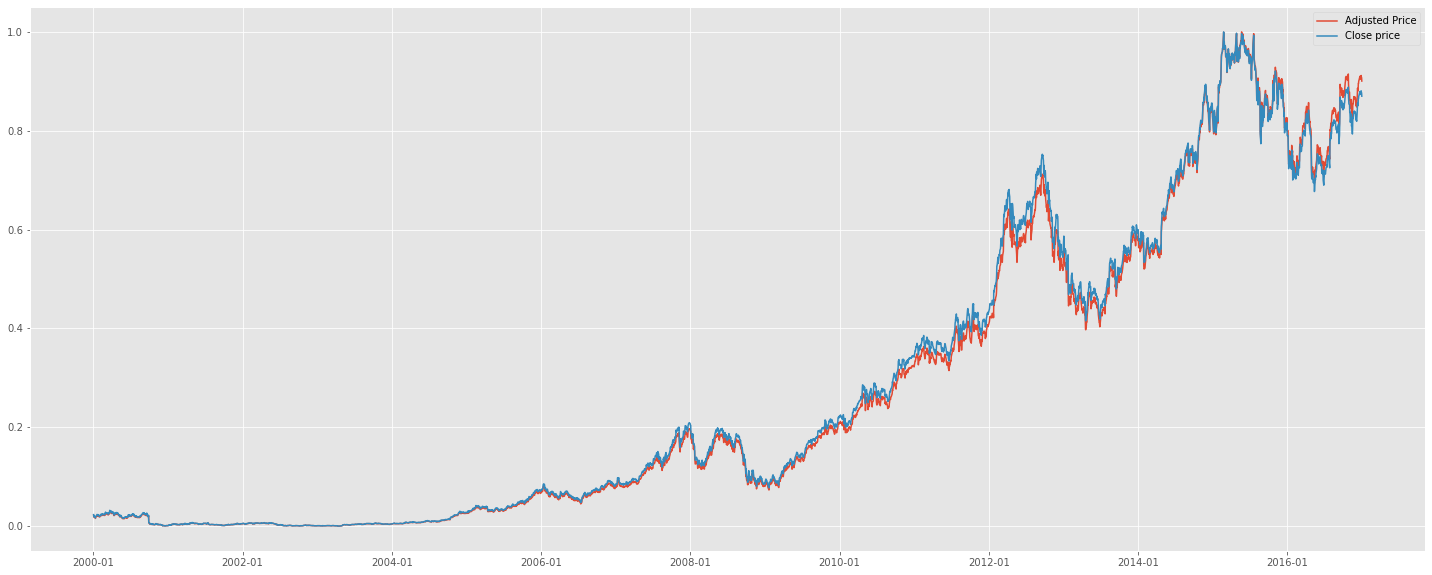

In [11]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates

scaler = MinMaxScaler()

#compare Adj Close and close price modified by stock splitting
fig, ax = plt.subplots(figsize=(25,10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.plot(Apple['Dt'], scaler.fit_transform(Apple['Adj Close'].values.reshape(-1,1)), label = 'Adjusted Price')
ax.plot(Apple['Dt'], scaler.fit_transform(Apple['Close'].values.reshape(-1,1)), label = 'Close price')
ax.legend()

In [12]:
print(Apple['Adj Close'].corr(Apple['Close']))
#Since Adj Close is pretty close to close price after adding stock splitting, I choose close price without stock splitting effect to calculate stock's daily return

0.9992293044297093


In [13]:
#calculate our target return
Apple['Ret'] = Apple['Close'].pct_change()

## Generate Discrete Target  
I split target returns into (25%, 25%, 25%, 25%), threshold (-1.1%, 0%, 1.4%), to aviod imbalance in target.

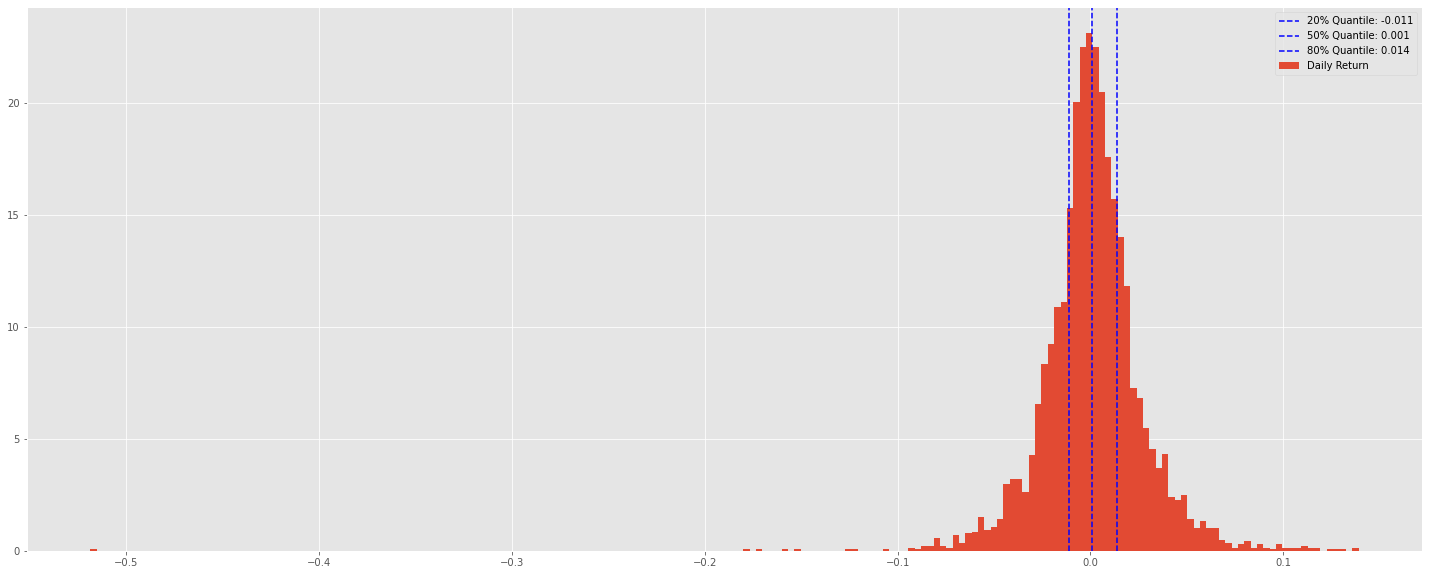

In [14]:
#look at the density distribution of historical returns as well as 25%, 50% and 75% quantile of target
thre = [Apple['Ret'].quantile(0.25), Apple['Ret'].quantile(0.5), Apple['Ret'].quantile(0.75)]

plt.figure(figsize = (25,10))
plt.hist(Apple['Ret'], bins = 200, density = True, label = 'Daily Return')
plt.axvline(thre[0], linestyle='dashed', color = 'b', label = '20% Quantile: {}'.format(round(thre[0], 3)))
plt.axvline(thre[1], linestyle='dashed', color = 'b', label = '50% Quantile: {}'.format(round(thre[1], 3)))
plt.axvline(thre[2], linestyle='dashed', color = 'b', label = '80% Quantile: {}'.format(round(thre[2], 3)))
plt.legend()

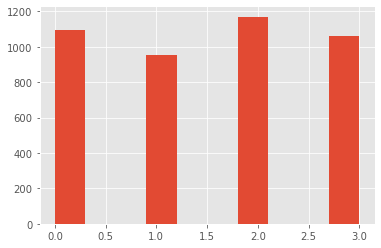

In [15]:
#Crete classification target and imbalance check
Apple['Retc'] = 3
Apple.loc[Apple['Ret'] < 0.014, 'Retc'] = 2
Apple.loc[Apple['Ret'] < 0, 'Retc'] = 1
Apple.loc[Apple['Ret'] < -0.011, 'Retc'] = 0
Apple['Retc'].hist()

# Data Preprocessing4: Capture Time Series Patterns
In order to capture more features to predict future returns, I specifically look at the time series patterns of AAPL's historical returns.  
My assumption is that there should be some unique time series patterns of AAPL returns before a high positive/negative return occurs. 

## Seasonality Checking  
The first thing I will do in this section is to check whether seasonality exists on AAPL's time series returns. If it exists, I will extract that seasonality from original features and add it as new features.

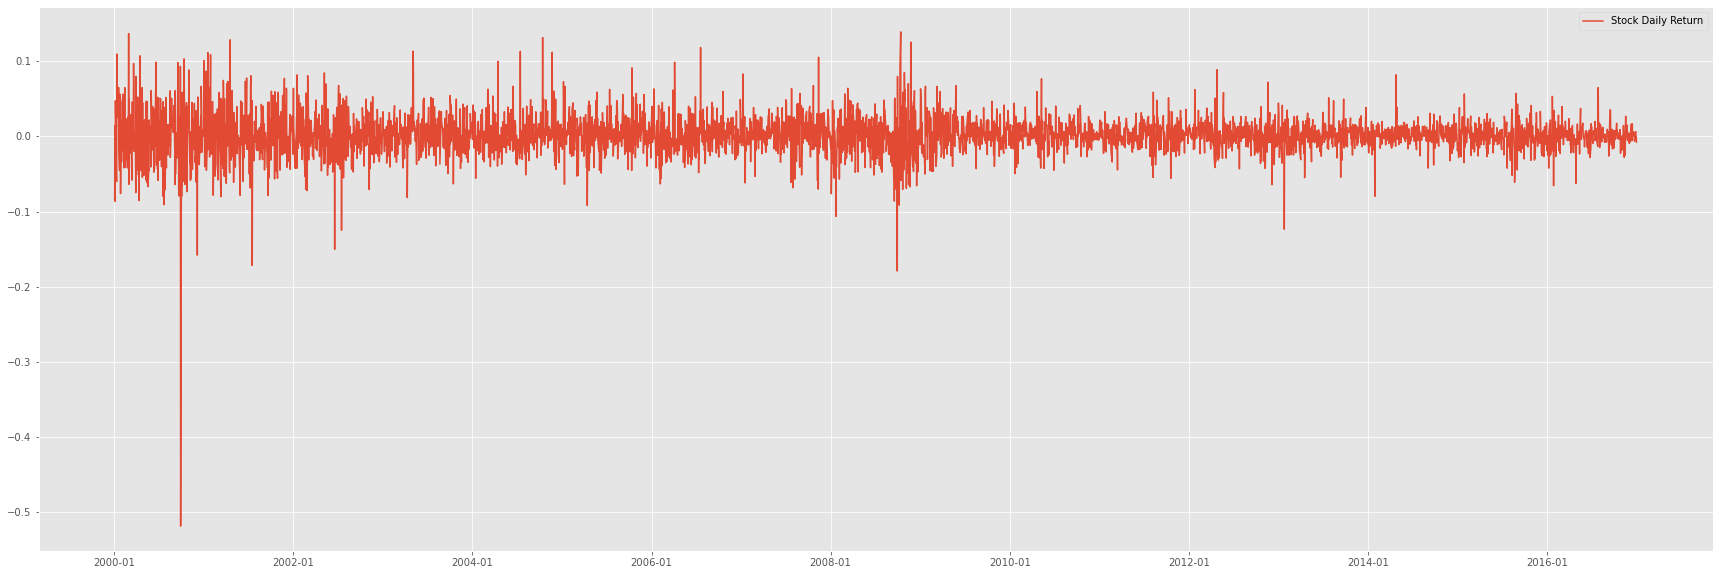

In [16]:
#Get AAPL return Time Series data
Ret = Apple[['Dt','Ret','Retc']].dropna()

fig, ax = plt.subplots(figsize=(30,10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.plot(Ret['Dt'], Ret['Ret'], label = 'Stock Daily Return')
ax.legend()

In [17]:
#Something strange in 2000? Stock price halved, so we look at it and find there is no mistake.
print("Big decline in {}".format(Ret.loc[Ret['Ret'] == Ret['Ret'].min(), 'Dt'].values))

Big decline in ['2000-09-29T00:00:00.000000000']


In [18]:
#stationary checking: we have a significant negative ADF and p-value close to 0, confidently reject the non hypothesis
from statsmodels.tsa.stattools import adfuller

result = adfuller(Ret['Ret'].values, autolag = 'AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
#We can conclude that AAPL return is stationary and has no seasonal trends
print('AAPL Return has no seasonality!')

ADF Statistic: -14.16133937297984
p-value: 2.0784188529664546e-26
AAPL Return has no seasonality!


## Time Series Clustering
In order to investigate time series patterns before a high positive/negative return occurs, I implement K-Mean clustering on the time series AAPL historical return data, attempting to generate significant features to predict future returns of AAPL.  
1. Firstly I standardize data, then transfer the historical return data into windows and split into my four target groups(0,1,2,3).  
2. Secondly I implement Dynamic Time Warping(DTW) K-Mean clustering in AAPL total data set and generate time series clusters. The reason to use DTW is that it can keep the order of time series data. 
3. Then I separate the labels into our four groups, and check the difference of label distribution in each group and generate insights.

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Ret['Ret'] = scaler.fit_transform(Ret['Ret'].values.reshape(-1,1))

In [20]:
#Generate time series return data
TSret = {}
for i in range(15,len(Ret)):   #choose the length of 15 time steps
    ret = Ret.iloc[i,2]
    date = Ret.iloc[i,0]
    list0 = Ret.iloc[i-15: i,1].values
    list0 = list0.tolist()
    list0.append(ret)
    TSret[date] = list0
    
TSret = pd.DataFrame(TSret, index = ['T{}'.format(i) for i in range(16)]).T
TSret = TSret.rename(columns = {'T15':'Target'})

In [21]:
#The columns are time series returns in the past 14 days(two weeks), and index is the date
TSret.head()

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,Target
2000-01-26,-3.194255,0.503378,-3.277362,1.726632,-0.700736,-1.954956,-2.284432,4.054832,1.380983,1.258730,0.900287,2.389159,-0.763545,-1.743202,2.066773,0.0
2000-01-27,0.503378,-3.277362,1.726632,-0.700736,-1.954956,-2.284432,4.054832,1.380983,1.258730,0.900287,2.389159,-0.763545,-1.743202,2.066773,-0.729950,1.0
2000-01-28,-3.277362,1.726632,-0.700736,-1.954956,-2.284432,4.054832,1.380983,1.258730,0.900287,2.389159,-0.763545,-1.743202,2.066773,-0.729950,-0.107247,0.0
2000-01-31,1.726632,-0.700736,-1.954956,-2.284432,4.054832,1.380983,1.258730,0.900287,2.389159,-0.763545,-1.743202,2.066773,-0.729950,-0.107247,-2.888643,3.0
2000-02-01,-0.700736,-1.954956,-2.284432,4.054832,1.380983,1.258730,0.900287,2.389159,-0.763545,-1.743202,2.066773,-0.729950,-0.107247,-2.888643,0.737910,0.0


In [105]:
#Implement DTW Time Series Clustering and find an appropriate number of clusters to seed for the kMeans
from tslearn.clustering import TimeSeriesKMeans

clusters_count = []
aggregate_distance = []
for num in range(3, 25):  
    TSK = TimeSeriesKMeans(n_clusters = num, metric = 'dtw', max_iter = 20).fit(TSret.iloc[:,:-1].values.reshape(len(TSret), len(TSret.columns) - 1, 1))
    clusters_count.append(num)
    aggregate_distance.append(TSK.inertia_)
    print('Finished cuslters {}'.format(num))

Finished cuslters 3
Finished cuslters 4
Finished cuslters 5
Finished cuslters 6
Finished cuslters 7
Finished cuslters 8
Finished cuslters 9
Finished cuslters 10
Finished cuslters 11
Finished cuslters 12
Finished cuslters 13
Finished cuslters 14
Finished cuslters 15
Finished cuslters 16
Finished cuslters 17
Finished cuslters 18
Finished cuslters 19
Finished cuslters 20
Finished cuslters 21
Finished cuslters 22
Finished cuslters 23
Finished cuslters 24


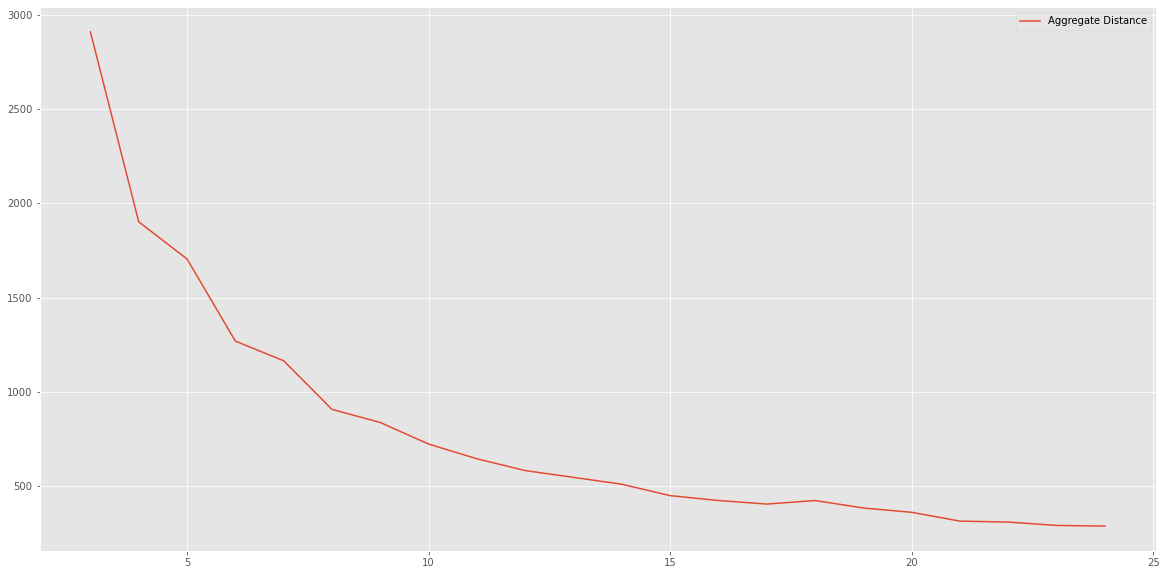

In [106]:
plt.figure(figsize = (20,10))
plt.plot(clusters_count, aggregate_distance, label = 'Aggregate Distance')
plt.legend()
#We can see from the figure as we increase the number of clusters, the aggregate distance decrease.
#I finally choose 8 clusters as the speed of decreasing slows down at that point

In [24]:
#Get the clusters
TSK = TimeSeriesKMeans(n_clusters = 8, metric = 'dtw', max_iter = 20).fit(TSret.iloc[:,:-1].values)
clusters = TSK.cluster_centers_
clusters.shape

(8, 15, 1)

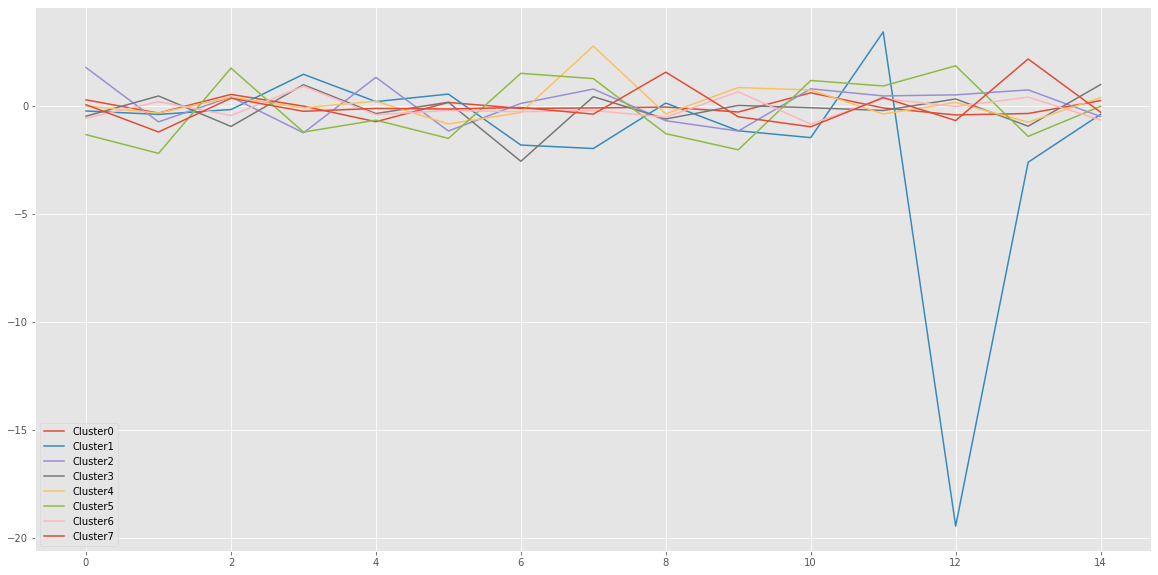

In [25]:
#Plot time series clusters
clusters = clusters.reshape(8,15)

plt.figure(figsize = (20,10))
for i in range(8):
    plt.plot(np.arange(15), clusters[i], label = 'Cluster{}'.format(i))
plt.legend()
#Actually there are no apparent patterns in these clusters....then we compare labels difference in each group

In [26]:
#Get labels in each group and get density distribution in each group
TSret['Label'] = TSK.labels_
value_counts = TSret.groupby(['Target'])['Label'].value_counts(normalize = True)

In [27]:
#Get density distribution matrix
Distribution = {}
for i in range(4):
    series = pd.Series([0]*8, index = range(8))
    clus = value_counts[i].sort_index(ascending = True)
    series[series.index.isin(clus.index)] = clus
    Distribution['group{}'.format(i)] = series.tolist()
    
Distribution = pd.DataFrame(Distribution, index = ['Cluster{}'.format(n) for n in range(8)])

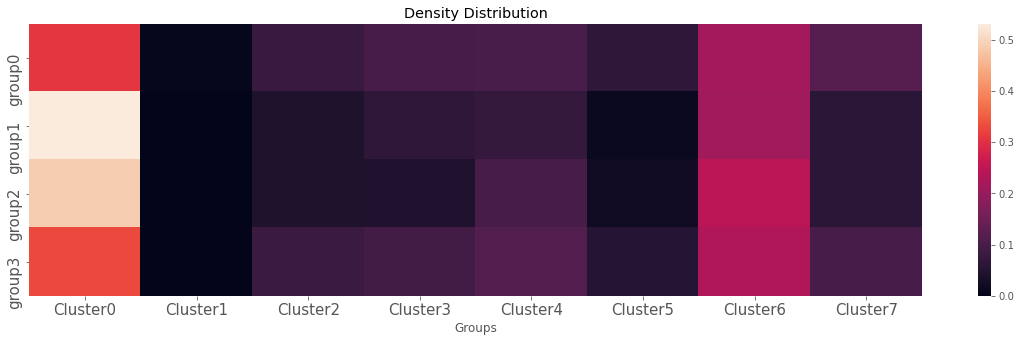

In [28]:
#Compare in a heat map
import seaborn as sn

plt.figure(figsize = (20,5))
ax = sn.heatmap(Distribution.T)
ax.set_xlabel("Clusters")
ax.set_xlabel("Groups")
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
ax.set_title("Density Distribution")
plt.show()

In [29]:
np.var(clusters, axis = 1)  #Cluster0 has the lowest variance

array([ 0.12298225, 24.80505966,  0.84759236,  0.73698199,  0.7107144 ,
        2.03013369,  0.24288065,  0.72453192])

In [24]:
#create standarded deviation features to measure volatility of stock price in past periods
Apple['Ret_std3'] = Apple['Ret'].rolling(3).std()
Apple['Ret_std10'] = Apple['Ret'].rolling(10).std()
Apple.head()

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Stk,Ret,Retc,Ret_std3,Ret_std10
0,2000-01-03,3.4785,111.938,0.0,1.0,112.500,101.688,104.8750,133949200.0,AAPL,NaN,3,NaN,NaN
1,2000-01-04,3.1852,102.500,0.0,1.0,110.625,101.188,108.2500,128094400.0,AAPL,-0.084315,0,NaN,NaN
2,2000-01-05,3.2318,104.000,0.0,1.0,110.563,103.000,103.7500,194580400.0,AAPL,0.014634,3,NaN,NaN
3,2000-01-06,2.9521,95.000,0.0,1.0,107.000,95.000,106.1183,191993200.0,AAPL,-0.086538,0,0.057781,NaN
4,2000-01-07,3.0920,99.500,0.0,1.0,101.000,95.500,96.5000,115183600.0,AAPL,0.047368,3,0.069807,NaN


In [25]:
#time series features list
features1 = ['Ret_std3','Ret_std10']
print(features1)

['Ret_std3', 'Ret_std10']


# Data Preprocessing2: Create Synthetic Features  
In this section, I will manually create two sets of synthetic features to predict stock return of Apple. And I will use significant test of linear (auto)correlation between target and features to conclude the significance of features. Once the feature pass the significant test, that is, surpass 80% confidence interval, [−1.28/√n,+1.28/√n]. I will use it to make prediction.
1. Autocorrelation and momentum time series strategy: use the historical trading data of Apple to predict future returns  
2. Companies interplay: utilize other companies' trading information to predict future returns

In [26]:
#Adjust High, Low, Open by stock splitting
Apple['High'] = Apple['High']*multiply
Apple['Low'] = Apple['Low']*multiply
Apple['Open'] = Apple['Open']*multiply

#Add a new feature: relative volume, adjust by stock splitting
Apple['Re_Volume'] = Apple['Volume']/multiply

## Autocorrelation and Momentum Features  
The followings are synthetic features of autocorrelation and momentum. Each contains analysis about its correlation to target and significance as the input in our prediction model

### Time Series Analysis of AAPL Return

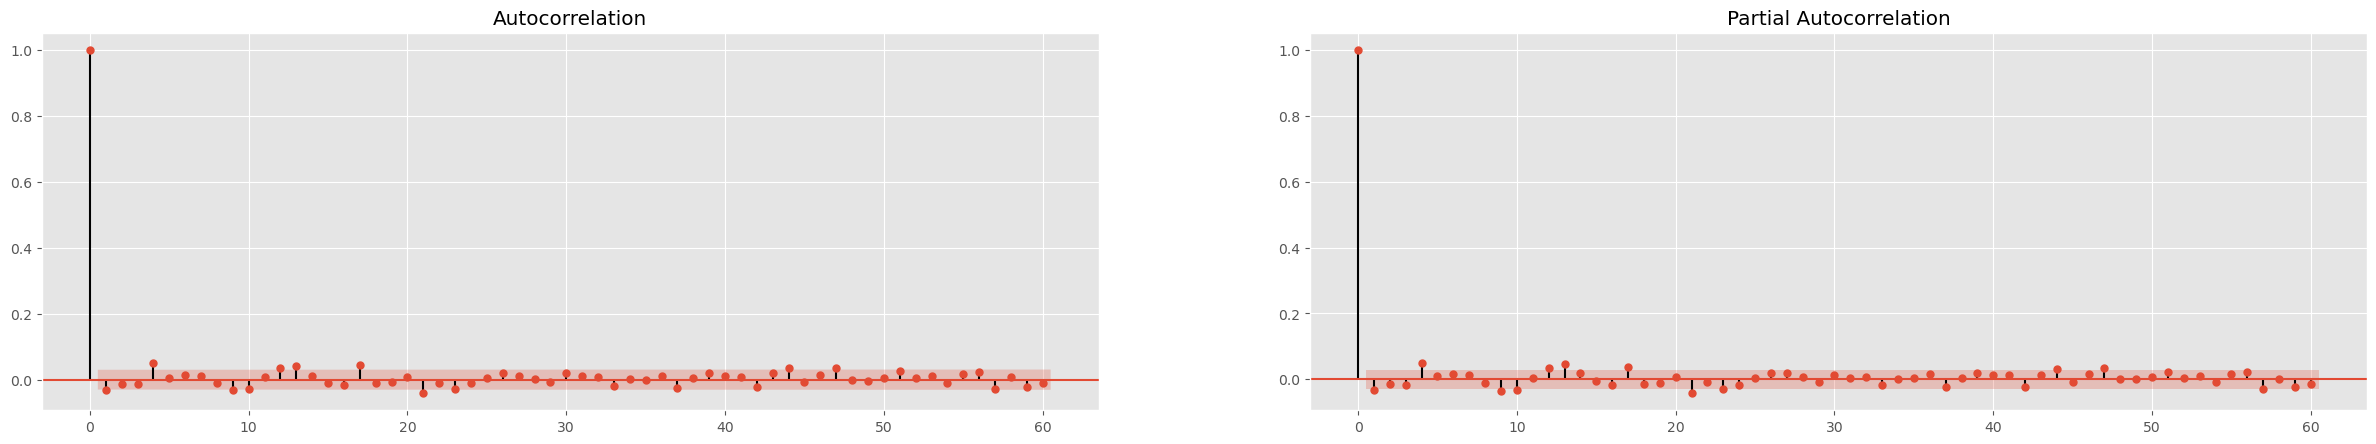

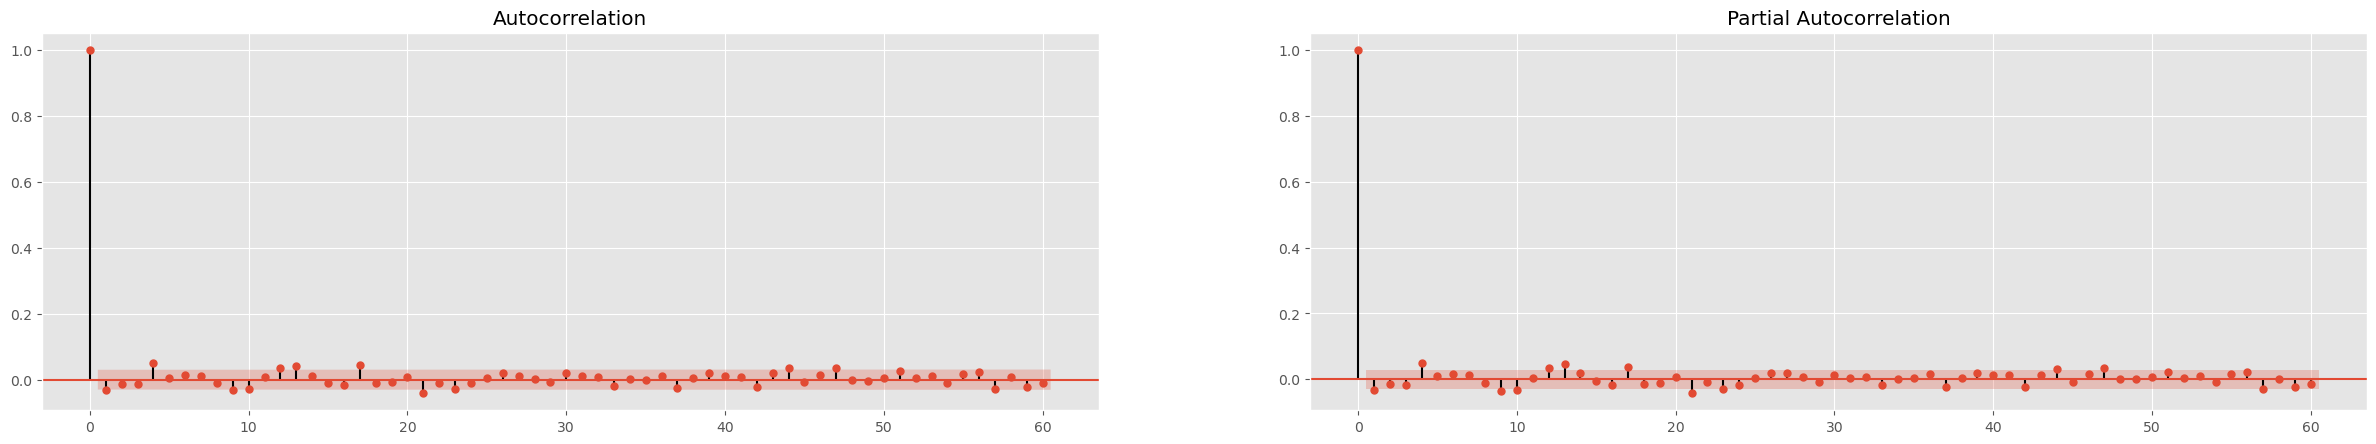

In [27]:
#ACF and PACF of return: The autocorrelation is weak, but still have some significant coorelation at t = 4, 13, 17, 21
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1,2,figsize=(30,5), dpi= 100)
plot_acf(Apple['Ret'].dropna(), lags=60, ax = axes[0])
plot_pacf(Apple['Ret'].dropna(), lags=60, ax = axes[1])

In [28]:
#We create new features by looking back the stock return in previous days, which tend to have a significant ACF and PACF
Apple['Ret1'] = Apple['Ret'].shift(1)
Apple['Ret4'] = Apple['Ret'].shift(4)
Apple['Ret13'] = Apple['Ret'].shift(13)
Apple['Ret17'] = Apple['Ret'].shift(17)
Apple['Ret21'] = Apple['Ret'].shift(21)

### Moving Average

In [29]:
#get moving average data
Apple['Close3'] = Apple['Close'].rolling(3).mean().shift(1)
Apple['Close5'] = Apple['Close'].rolling(5).mean().shift(1)
Apple['Close10'] = Apple['Close'].rolling(10).mean().shift(1)
Apple['Close30'] = Apple['Close'].rolling(30).mean().shift(1)
Apple['Close60'] = Apple['Close'].rolling(60).mean().shift(1)

In [30]:
#investigate correlation between features and target with significant test
def get_correlation(data, feature_list):
    
    feature_list.append('Retc')
    corr = data[feature_list].corr()
    corr = corr['Retc'].drop('Retc')
    
    length = min(len(feature_list)*3, 30)
    plt.figure(figsize = (length, 8))
    plt.bar(corr.index, corr.values, label = 'Correlation', alpha = 0.8)
    plt.xticks(rotation = 90)
    plt.axhline(y = 0.019, linestyle='dashed', color = 'b')  #benchmark 80% confidence interval, [−1.28/√n,+1.28/√n]
    plt.axhline(y = -0.019, linestyle='dashed', color = 'b')

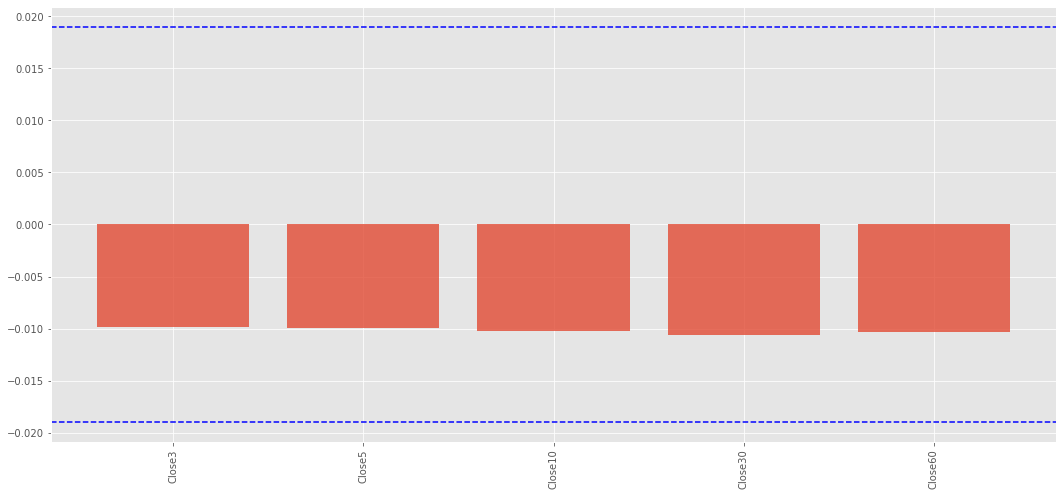

In [31]:
#We can see the moving averages are weakly negative correlated with return, so we will not use it
get_correlation(Apple, ['Close3','Close5','Close10','Close30','Close60'])

In [32]:
#get moving average strategies
Apple['Diff3'] = Apple['Close'].shift(1) - Apple['Close3']
Apple['Diff5'] = Apple['Close3'] - Apple['Close5']
Apple['Diff10'] = Apple['Close5'] - Apple['Close10']
Apple['Diff30'] = Apple['Close10'] - Apple['Close30']
Apple['Diff60'] = Apple['Close30'] - Apple['Close60']

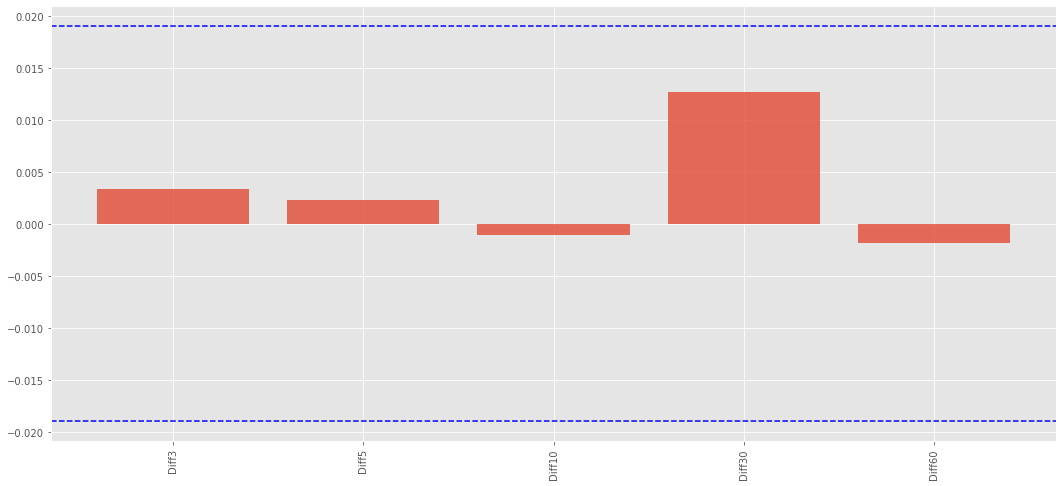

In [33]:
#difference between moving averages perform bad, we will not use it
get_correlation(Apple, ['Diff3','Diff5','Diff10','Diff30','Diff60'])

### Disaggrement Analysis

In [34]:
def get_disaggrement(data, period):
    
    Pct_change = data['Close'] - data['Open'].shift(period-1)
    Dis = Pct_change/data['Re_Volume'].rolling(period).sum()
    
    return Dis

In [35]:
Apple['Dis1'] = get_disaggrement(Apple[['Close','Open','Re_Volume']], 1).shift(1)
Apple['Dis3'] = get_disaggrement(Apple[['Close','Open','Re_Volume']], 3).shift(1)
Apple['Dis5'] = get_disaggrement(Apple[['Close','Open','Re_Volume']], 5).shift(1)
Apple['Dis10'] = get_disaggrement(Apple[['Close','Open','Re_Volume']], 10).shift(1)
Apple['Dis30'] = get_disaggrement(Apple[['Close','Open','Re_Volume']], 30).shift(1)
Apple['Dis60'] = get_disaggrement(Apple[['Close','Open','Re_Volume']], 60).shift(1)

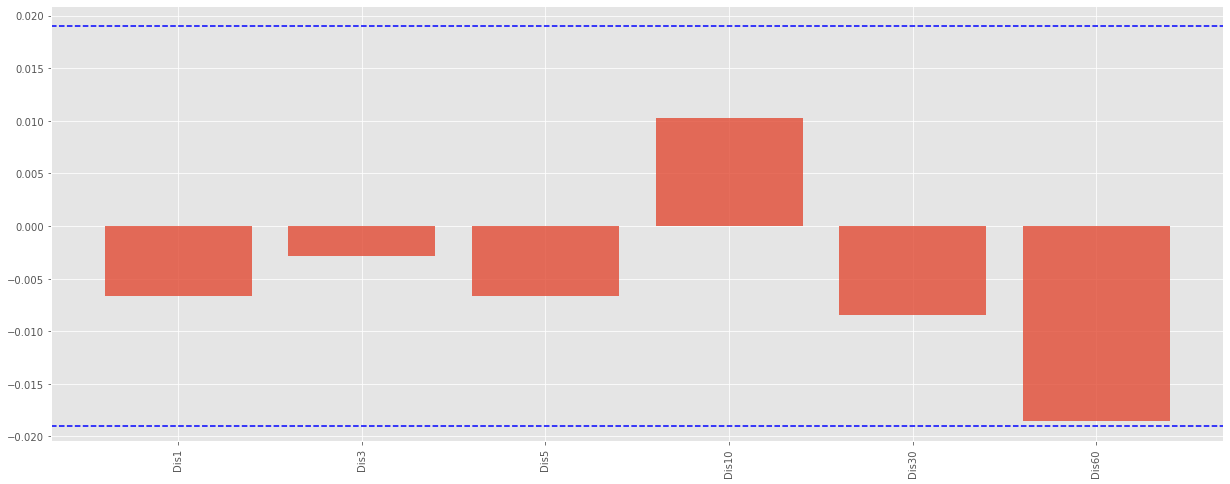

In [36]:
#Disaggrement shows weak correlation to return, drop them
get_correlation(Apple, ['Dis1','Dis3','Dis5','Dis10','Dis30','Dis60'])

### Intra-day Price Change

In [37]:
Apple['Highback'] = (1 - Apple['High']/Apple['Close']).shift(1)
Apple['Lowup'] = (1 - Apple['Low']/Apple['Close']).shift(1)
Apple['Range'] = ((Apple['High'] - Apple['Low'])/Apple['Close']).shift(1)
Apple['Jump'] = (Apple['Open']/Apple['Close'].shift(1) - 1).shift(1)

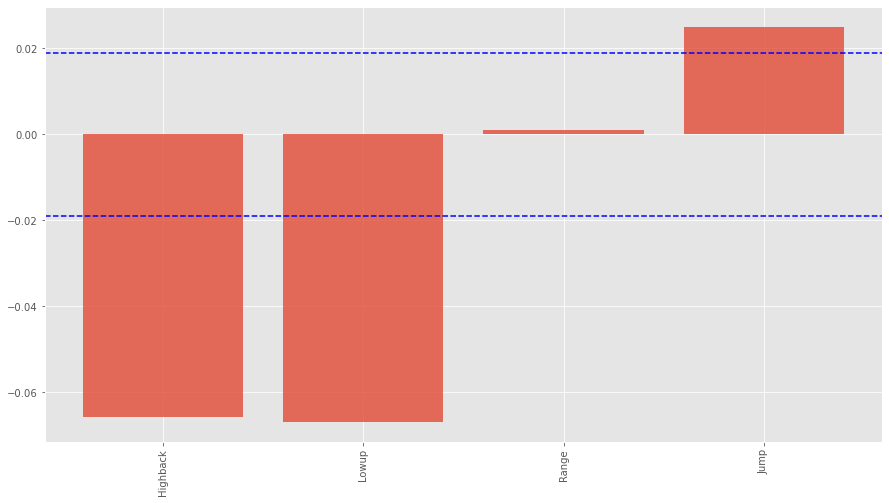

In [38]:
#Good news！Best linear correlation till now. Highback, Lowup and Jump works well
get_correlation(Apple, ['Highback','Lowup','Range','Jump'])

### Section Summary  
In this section, we create synthetic features of autocorrelation and momentum--Autocorrelation of target, moving averages, disaggrement indicators and Intra-day price patterns. After significant test, only 10 features in Autocorrelation of target and Intra-day price patterns are left.

In [39]:
#drop insignificant features 
Apple = Apple.drop(columns = ['Close3','Close5','Close10','Close30','Close60','Diff3','Diff5','Diff10','Diff30','Diff60','Dis1','Dis3','Dis5','Dis30','Range'])

In [40]:
#Current columns we have
Apple.columns

Index(['Dt', 'Adj Close', 'Close', 'Div', 'Factor', 'High', 'Low', 'Open',
       'Volume', 'Stk', 'Ret', 'Retc', 'Ret_std3', 'Ret_std10', 'Re_Volume',
       'Ret1', 'Ret4', 'Ret13', 'Ret17', 'Ret21', 'Dis10', 'Dis60', 'Highback',
       'Lowup', 'Jump'],
      dtype='object')

In [41]:
#Autocorrelation and Momentum features
features2 = Apple.columns.tolist()[15:]
print(features2)
print(len(features2))

['Ret1', 'Ret4', 'Ret13', 'Ret17', 'Ret21', 'Dis10', 'Dis60', 'Highback', 'Lowup', 'Jump']
10


## Companies Interplay  
The followings are synthetic features of companies interplay. Each contains analysis about its correlation to target and significance as the input in our prediction model

In [42]:
#all companies
print(stk_list)

['AAPL', 'ACN', 'ADBE', 'CRM', 'CSCO', 'FB', 'GOOG', 'IBM', 'INTC', 'MA', 'MSFT', 'NVDA', 'SPY', 'V', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY']


In [43]:
company = data[data['Stk'].isin(stk_list[1:])].copy()
company.shape

(98371, 10)

### Stock Splitting Checking  
Eliminate stock splitting effect on price data, the same process which I have conducted for AAPL.

In [44]:
#Firstly we take a look at the stock splitting effect, find all stock split cases
split_index = company[company['Factor'] > 1].index
pre_split_index = split_index - 1

split = split_index.tolist()
pre_split = pre_split_index.tolist()
split.extend(pre_split)
print(split)

[7295, 8760, 9908, 16173, 17164, 29241, 34361, 42027, 43553, 47169, 47472, 47473, 48621, 48979, 59426, 72636, 7294, 8759, 9907, 16172, 17163, 29240, 34360, 42026, 43552, 47168, 47471, 47472, 48620, 48978, 59425, 72635]


In [45]:
#It is tricky that some companies' close price already contains stock split effect(stock price has little change agter a stock split), and some are not....
split_info = company[company.index.isin(split)].copy()
split_info

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume,Stk
7294,2011-12-29,45.2288,53.8400,0.0000,1.000,53.9100,52.7300,53.0900,3293400.0,ACN
7295,2011-12-30,44.7164,53.2300,0.0000,10.000,53.8000,53.2200,53.5116,2332800.0,ACN
8759,2000-10-24,33.5784,135.1880,0.0000,1.000,145.3750,135.0000,143.0000,7648400.0,ADBE
8760,2000-10-25,33.5319,67.5000,0.0000,2.000,72.3750,65.6250,66.4060,6066000.0,ADBE
9907,2005-05-23,31.3600,62.7200,0.0000,1.000,63.2500,61.8700,62.0000,5379200.0,ADBE
9908,2005-05-24,32.4200,32.4200,0.0000,2.000,32.5000,31.2700,31.4204,6500200.0,ADBE
16172,2013-04-17,41.8375,167.3500,0.0000,1.000,170.6600,165.6516,168.8500,22142000.0,CRM
16173,2013-04-18,41.0300,41.0300,0.0000,4.000,41.9100,40.7600,41.1700,4476800.0,CRM
17163,2000-03-22,56.2922,144.3750,0.0000,1.000,146.7500,138.8750,141.6250,59111600.0,CSCO
17164,2000-03-23,60.6786,77.8130,0.0000,2.000,78.9380,72.0000,73.1250,76967200.0,CSCO


In [46]:
#modify the cases of effective stock split, that is, cases there is little change in stock price/adj close
def real_factor(data):

    fake_Factor = []
    for i in split_index:
        pre_i = i - 1
        pre_ratio = data.loc[pre_i, 'Close']/data.loc[pre_i, 'Adj Close']
        ratio = data.loc[i, 'Close']/data.loc[i, 'Adj Close']
        if abs(pre_ratio - ratio) < 0.01:
            fake_Factor.append(i)
    
    data.loc[fake_Factor, 'Factor'] = 1
    print('Modify Factor in {}'.format(fake_Factor))
    
    return data      

In [47]:
company = real_factor(company)

Modify Factor in [7295, 29241, 34361, 47472]


In [48]:
#Define a function to modify prices by stock splitting
def stock_split(data):
    
    multiply = data['Factor'].cumprod()
    data['Close'] = data['Close']*multiply
    data['Open'] = data['Open']*multiply
    data['High'] = data['High']*multiply
    data['Low'] = data['Low']*multiply
    
    return data

In [49]:
#Get our data set without stock split effect
company = company.groupby(['Stk']).apply(lambda x:stock_split(x))

### Return on other Stocks

In [50]:
#get daily returns of stocks
company['Ret'] = company.groupby(['Stk'])['Close'].pct_change()

In [51]:
#create synthetic features of delayed returns
def get_returns(data, target, stklist):
    
    for stk in stklist:
        tmp = data[data['Stk'] == stk].copy()
        tmp['Ret1_{}'.format(stk)] = tmp['Ret'].shift(1)  #return on last 1 day
        tmp['Ret4_{}'.format(stk)] = tmp['Ret'].shift(4) #return on last 4 day
        tmp['Ret10_{}'.format(stk)] = tmp['Ret'].shift(10) #return on last 10 day
        tmp['Ret40_{}'.format(stk)] = tmp['Ret'].shift(40) #return on last 40 day
        
        target = target.merge(tmp[['Dt','Ret1_{}'.format(stk),'Ret4_{}'.format(stk),'Ret10_{}'.format(stk),'Ret40_{}'.format(stk)]], on = ['Dt'])
        
    return target

In [52]:
Apple1 = Apple[['Dt','Retc']].copy()
Apple1 = get_returns(company, Apple1, stk_list[1:])

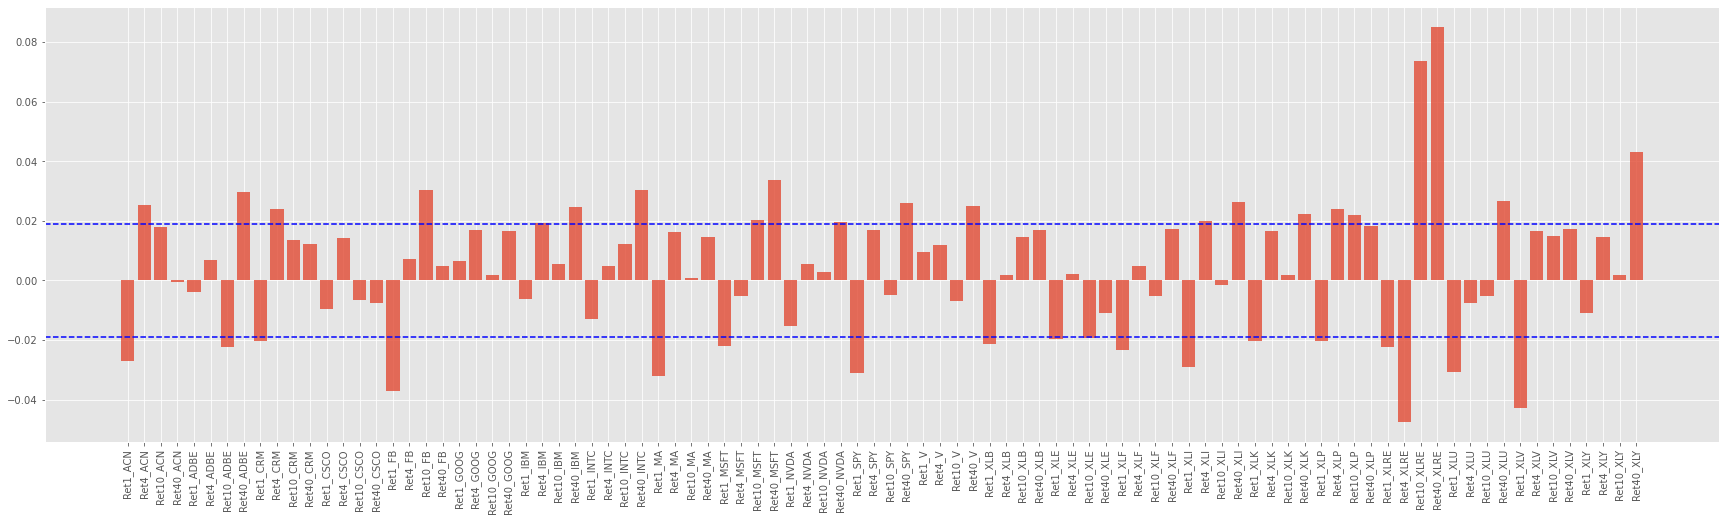

In [53]:
#Some compnaies' past returns have a significant correlation to AAPL return! Such as XLRE. And companies such as GOOG has really weak correlation
get_correlation(Apple1, Apple1.columns.tolist()[2:])

In [54]:
#drop weak correlated companies:CSCO, GOOG
for item in ['CSCO','GOOG']:
    stk_list.remove(item)
print(stk_list)

['AAPL', 'ACN', 'ADBE', 'CRM', 'FB', 'IBM', 'INTC', 'MA', 'MSFT', 'NVDA', 'SPY', 'V', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY']


In [55]:
#drop weak correlated companies:CSCO, GOOG
company = company[~company['Stk'].isin(['CSCO','GOOG'])].copy()
Apple1 = Apple[['Dt','Retc']].copy()
Apple1 = get_returns(company, Apple1, stk_list[1:])

### Section Summary  
In this section, I conduct research on companies' stock price interplay effect. And I do find significance of other companies' historical return to predict AAPL's future return. Till now I have finished all of the analysis to discover synthetic features in my project, and here are all the features we have:

In [56]:
#Interplay features
features3 = Apple1.columns.tolist()[2:]
print(features3)

['Ret1_ACN', 'Ret4_ACN', 'Ret10_ACN', 'Ret40_ACN', 'Ret1_ADBE', 'Ret4_ADBE', 'Ret10_ADBE', 'Ret40_ADBE', 'Ret1_CRM', 'Ret4_CRM', 'Ret10_CRM', 'Ret40_CRM', 'Ret1_FB', 'Ret4_FB', 'Ret10_FB', 'Ret40_FB', 'Ret1_IBM', 'Ret4_IBM', 'Ret10_IBM', 'Ret40_IBM', 'Ret1_INTC', 'Ret4_INTC', 'Ret10_INTC', 'Ret40_INTC', 'Ret1_MA', 'Ret4_MA', 'Ret10_MA', 'Ret40_MA', 'Ret1_MSFT', 'Ret4_MSFT', 'Ret10_MSFT', 'Ret40_MSFT', 'Ret1_NVDA', 'Ret4_NVDA', 'Ret10_NVDA', 'Ret40_NVDA', 'Ret1_SPY', 'Ret4_SPY', 'Ret10_SPY', 'Ret40_SPY', 'Ret1_V', 'Ret4_V', 'Ret10_V', 'Ret40_V', 'Ret1_XLB', 'Ret4_XLB', 'Ret10_XLB', 'Ret40_XLB', 'Ret1_XLE', 'Ret4_XLE', 'Ret10_XLE', 'Ret40_XLE', 'Ret1_XLF', 'Ret4_XLF', 'Ret10_XLF', 'Ret40_XLF', 'Ret1_XLI', 'Ret4_XLI', 'Ret10_XLI', 'Ret40_XLI', 'Ret1_XLK', 'Ret4_XLK', 'Ret10_XLK', 'Ret40_XLK', 'Ret1_XLP', 'Ret4_XLP', 'Ret10_XLP', 'Ret40_XLP', 'Ret1_XLRE', 'Ret4_XLRE', 'Ret10_XLRE', 'Ret40_XLRE', 'Ret1_XLU', 'Ret4_XLU', 'Ret10_XLU', 'Ret40_XLU', 'Ret1_XLV', 'Ret4_XLV', 'Ret10_XLV', 'Ret40_X

In [57]:
#All synthetic features in section5
features1.extend(features2)
features1.extend(features3)
print(features1)

['Ret_std3', 'Ret_std10', 'Ret1', 'Ret4', 'Ret13', 'Ret17', 'Ret21', 'Dis10', 'Dis60', 'Highback', 'Lowup', 'Jump', 'Ret1_ACN', 'Ret4_ACN', 'Ret10_ACN', 'Ret40_ACN', 'Ret1_ADBE', 'Ret4_ADBE', 'Ret10_ADBE', 'Ret40_ADBE', 'Ret1_CRM', 'Ret4_CRM', 'Ret10_CRM', 'Ret40_CRM', 'Ret1_FB', 'Ret4_FB', 'Ret10_FB', 'Ret40_FB', 'Ret1_IBM', 'Ret4_IBM', 'Ret10_IBM', 'Ret40_IBM', 'Ret1_INTC', 'Ret4_INTC', 'Ret10_INTC', 'Ret40_INTC', 'Ret1_MA', 'Ret4_MA', 'Ret10_MA', 'Ret40_MA', 'Ret1_MSFT', 'Ret4_MSFT', 'Ret10_MSFT', 'Ret40_MSFT', 'Ret1_NVDA', 'Ret4_NVDA', 'Ret10_NVDA', 'Ret40_NVDA', 'Ret1_SPY', 'Ret4_SPY', 'Ret10_SPY', 'Ret40_SPY', 'Ret1_V', 'Ret4_V', 'Ret10_V', 'Ret40_V', 'Ret1_XLB', 'Ret4_XLB', 'Ret10_XLB', 'Ret40_XLB', 'Ret1_XLE', 'Ret4_XLE', 'Ret10_XLE', 'Ret40_XLE', 'Ret1_XLF', 'Ret4_XLF', 'Ret10_XLF', 'Ret40_XLF', 'Ret1_XLI', 'Ret4_XLI', 'Ret10_XLI', 'Ret40_XLI', 'Ret1_XLK', 'Ret4_XLK', 'Ret10_XLK', 'Ret40_XLK', 'Ret1_XLP', 'Ret4_XLP', 'Ret10_XLP', 'Ret40_XLP', 'Ret1_XLRE', 'Ret4_XLRE', 'Ret10_X

In [58]:
#Get all features
features1.extend(['High','Low','Open','Volume'])
print(features1)

['Ret_std3', 'Ret_std10', 'Ret1', 'Ret4', 'Ret13', 'Ret17', 'Ret21', 'Dis10', 'Dis60', 'Highback', 'Lowup', 'Jump', 'Ret1_ACN', 'Ret4_ACN', 'Ret10_ACN', 'Ret40_ACN', 'Ret1_ADBE', 'Ret4_ADBE', 'Ret10_ADBE', 'Ret40_ADBE', 'Ret1_CRM', 'Ret4_CRM', 'Ret10_CRM', 'Ret40_CRM', 'Ret1_FB', 'Ret4_FB', 'Ret10_FB', 'Ret40_FB', 'Ret1_IBM', 'Ret4_IBM', 'Ret10_IBM', 'Ret40_IBM', 'Ret1_INTC', 'Ret4_INTC', 'Ret10_INTC', 'Ret40_INTC', 'Ret1_MA', 'Ret4_MA', 'Ret10_MA', 'Ret40_MA', 'Ret1_MSFT', 'Ret4_MSFT', 'Ret10_MSFT', 'Ret40_MSFT', 'Ret1_NVDA', 'Ret4_NVDA', 'Ret10_NVDA', 'Ret40_NVDA', 'Ret1_SPY', 'Ret4_SPY', 'Ret10_SPY', 'Ret40_SPY', 'Ret1_V', 'Ret4_V', 'Ret10_V', 'Ret40_V', 'Ret1_XLB', 'Ret4_XLB', 'Ret10_XLB', 'Ret40_XLB', 'Ret1_XLE', 'Ret4_XLE', 'Ret10_XLE', 'Ret40_XLE', 'Ret1_XLF', 'Ret4_XLF', 'Ret10_XLF', 'Ret40_XLF', 'Ret1_XLI', 'Ret4_XLI', 'Ret10_XLI', 'Ret40_XLI', 'Ret1_XLK', 'Ret4_XLK', 'Ret10_XLK', 'Ret40_XLK', 'Ret1_XLP', 'Ret4_XLP', 'Ret10_XLP', 'Ret40_XLP', 'Ret1_XLRE', 'Ret4_XLRE', 'Ret10_X

In [59]:
#Get our training data
Apple2 = Apple.merge(Apple1, on = ['Dt','Retc'])
train = Apple2[features1].copy()
train['Target'] = Apple2['Retc']
train.index = Apple2['Dt']
train[['High','Low','Open','Volume']] = train[['High','Low','Open','Volume']].shift(1)
train.head()

,Ret_std3,Ret_std10,Ret1,Ret4,Ret13,Ret17,Ret21,Dis10,Dis60,Highback,...,Ret40_XLV,Ret1_XLY,Ret4_XLY,Ret10_XLY,Ret40_XLY,High,Low,Open,Volume,Target
Dt,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005021,...,NaN,NaN,NaN,NaN,NaN,112.500,101.688,104.8750,133949200.0,0
2000-01-05,NaN,NaN,-0.084315,NaN,NaN,NaN,NaN,NaN,NaN,-0.079268,...,NaN,-0.030075,NaN,NaN,NaN,110.625,101.188,108.2500,128094400.0,3
2000-01-06,0.057781,NaN,0.014634,NaN,NaN,NaN,NaN,NaN,NaN,-0.063106,...,NaN,-0.012321,NaN,NaN,NaN,110.563,103.000,103.7500,194580400.0,0
2000-01-07,0.069807,NaN,-0.086538,NaN,NaN,NaN,NaN,NaN,NaN,-0.126316,...,NaN,0.011400,NaN,NaN,NaN,107.000,95.000,106.1183,191993200.0,3


# Data Preprocessing3: Missing Data Checking  
In this section, I attempt two different methods to deal with missing values and apply both in later modeling process. I will choose the approch tends to have a better performance to make predictions.

## Missing Values by Features Calculation  
Drop the NAN values by our feature calculation

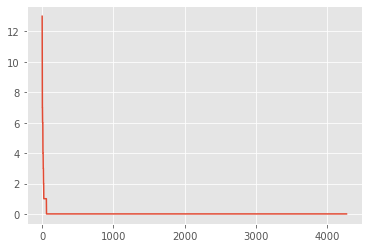

In [60]:
#plot NAN values in AAPL features
Apple.apply(lambda x:x.isna(), axis = 1).sum(axis = 1).plot()

In [61]:
#We drop these timesteps, the first 60th examples, so now our data start at 2000-03-29
train = train[train.index.isin(Apple.loc[Apple.apply(lambda x:x.isna(), axis = 1).sum(axis = 1) == 0, 'Dt'])].copy()
train.head()

,Ret_std3,Ret_std10,Ret1,Ret4,Ret13,Ret17,Ret21,Dis10,Dis60,Highback,...,Ret40_XLV,Ret1_XLY,Ret4_XLY,Ret10_XLY,Ret40_XLY,High,Low,Open,Volume,Target
Dt,,,,,,,,,,,,,,,,,,,,,
2000-03-29,0.014909,0.041961,-0.003138,-0.019939,0.028630,-0.018063,0.012141,2.400902e-08,4.979202e-09,-0.020665,...,0.012986,0.003324,0.002767,0.060452,0.036209,142.000,137.125,137.250,50741600.0,0
2000-03-30,0.037093,0.049339,-0.022907,-0.018576,-0.035284,-0.022381,0.136864,2.007317e-08,4.068999e-09,-0.025747,...,0.024590,0.019841,0.003290,0.074792,-0.006670,139.438,133.828,139.375,59959200.0,0
2000-03-31,0.078865,0.054552,-0.074946,0.006309,-0.058221,-0.007121,-0.063793,6.003648e-09,3.244777e-09,-0.094934,...,0.008992,0.022116,-0.002750,-0.000530,0.003893,137.688,125.438,133.563,103600000.0,3
2000-04-03,0.078423,0.054683,0.080024,-0.003138,0.017505,0.002049,0.049180,1.280167e-08,4.440857e-09,-0.010581,...,0.003489,-0.010548,0.003324,-0.009411,-0.001636,137.250,126.000,127.438,101158400.0,0
2000-04-04,0.065865,0.047341,-0.018408,-0.022907,0.045703,0.028630,-0.018063,1.082746e-08,5.597358e-09,-0.046410,...,-0.016308,0.029898,0.019841,0.011179,-0.021167,139.500,129.438,135.500,82140800.0,0


## Original Missing Values of Companies  
Some companies were not listed as early as in 2000, so we have some companies without early historical stock price information.

In [62]:
#check missing data in each company
Nan_check = {}
for stk in stk_list:
    tmp = data[data['Stk'] == stk].copy()
    Nan_check[stk] = len(tmp.dropna())/len(tmp)
    
Nan_check = pd.DataFrame(Nan_check, index = [0])
Nan_check

,AAPL,ACN,ADBE,CRM,FB,IBM,INTC,MA,MSFT,NVDA,...,XLB,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
0,1.0,0.909048,1.0,0.737667,0.27192,1.0,1.0,0.624269,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.072715,1.0,1.0,1.0


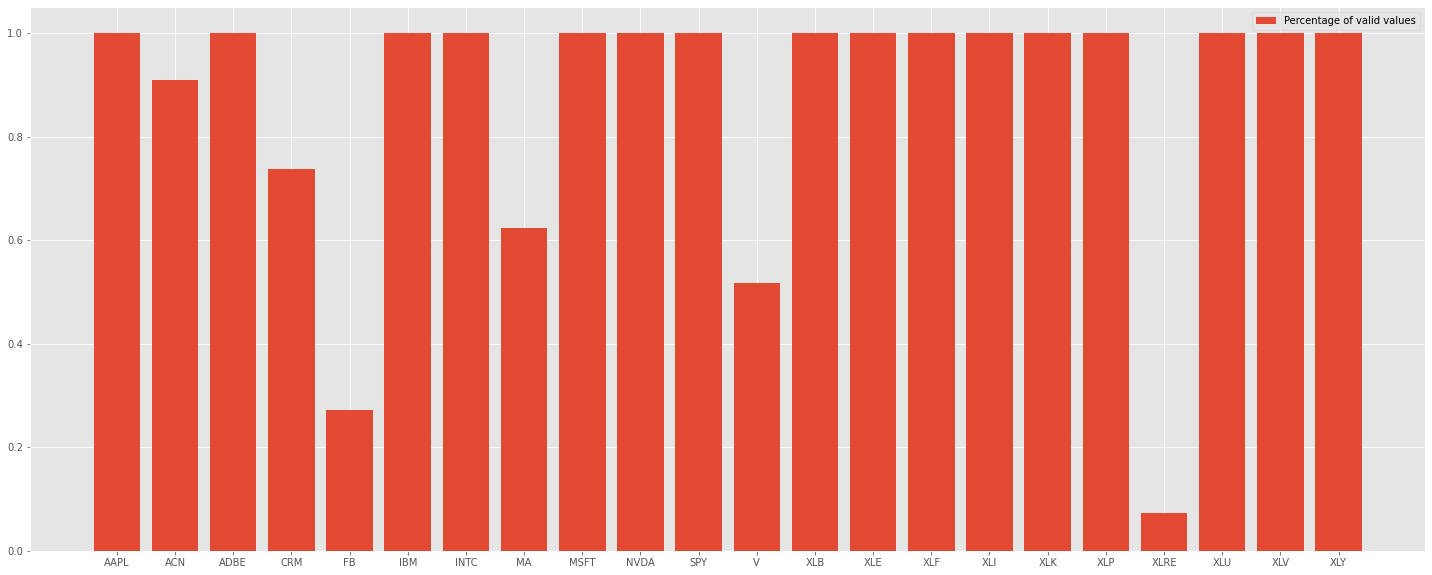

In [63]:
#percentage of missing data in each company
plt.figure(figsize = (25,10))
plt.bar(Nan_check.columns.tolist(), Nan_check.values[0], label = 'Percentage of valid values')
plt.legend()

In [64]:
#define two ways to deal with missing data
def fill_nan(df):
    return df.fillna(0)

def drop_nan(df):
    return df.dropna(axis = 1)

# Implement Benchmark Model  
In this section, I will implement Xgboost as our benchmark model.  
1. Firstly, I utilize the benchmark model to determine which method I will choose to deal with missing data by comparing model performance in each method.
2. Secondly, I build confusion matrix to evaluate my benchmark model and prepare for further comparision with my final model.

In [69]:
#define features matrix X and target y with two methods of dealing with missing data:fill nan and drop nan columns
X1 = fill_nan(train).iloc[:,:-1].values
y1 = fill_nan(train)['Target'].values

X2 = drop_nan(train).iloc[:,:-1].values
y2 = drop_nan(train)['Target'].values

print(X1.shape)
print(y1.shape)
print(X2.shape)
print(y2.shape)

(4217, 100)
(4217,)
(4217, 76)
(4217,)


## Standardization and TimeSeries Split  
In order to make features comparable and avoid looking at future data, I construct a pipeline with standardization process when running the model and choose time series split when cross valid my training data.

In [66]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
xgb_b = xgb.XGBClassifier(objective = 'multi:softprob', use_label_encoder=False) #multi-classification problem

pipeline = Pipeline(steps = [('transform',scaler),
                             ('XGB',xgb_b)])

In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits = 50)

#print training and validation indexes in cross validation
for train_index, test_index in tscv.split(train):
     print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116] TEST: [117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41

## Evaluation Matrics  

1. Because it is a multi-label classification problem, I use overall accuracy to train my model. Then I determine the method to deal with missing data by comparing accuracy scores in the validation set. And in order to preprocess my validation set in the same way as my training set, I build a data transformation function, containing all my previous processes to transform my training data.
2. The purpose of my project is to get a better accuracy in groups my model predicts as 0 and 3. So I specifically pay attention precision in label 0 and 3 in the confusion matrix. My goal is to optimize precision in label 0 and 3 in order to maximize my long/short win ratio.
3. I will create another metric to evaluate my models: Considering that my prediction model informs me to long or short tomorrow, under no circumstances should I lose money. That is, when I long the AAPL position, the real return in the next day should fall in (High positive, Low Positive) returns. And when I short, it should fall in (High negative, Low negative). In this case, I create the new matric:  
WinRatio_positive = number of positive returns in predicted 3/total number of returns in predicted 3  
WinRatio_negative = number of negative returns in predicted 0/total number of returns in predicted 0  
It is a modified precision which measure the win ratio of my trading strategy more accurately, even though the prediction may be wrong(predict 3 but real 2)

In [70]:
params = {'XGB__alpha': [3],
          'XGB__colsample_bytree': [0.3],
          'XGB__learning_rate': [0.25],
          'XGB__lambda':[2],
          'XGB__max_depth': [4],
          'XGB__n_estimators': [70]}

#missing data approach1
gs1 = GridSearchCV(pipeline, params, refit = True, cv = tscv, scoring = 'accuracy', verbose = 10)
gs1.fit(X1, y1)

Fitting 50 folds for each of 1 candidates, totalling 50 fits
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[18:34:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.402, total=   0.1s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[18:34:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merr

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.317, total=   0.1s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[18:34:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.366, total=   0.1s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[18:34:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.378, total=   0.2s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[18:34:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.451, total=   0.2s

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s



[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[18:34:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.305, total=   0.2s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[18:34:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like 

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.0s remaining:    0.0s


[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.232, total=   0.3s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[18:34:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.2s remaining:    0.0s


[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.341, total=   0.3s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[18:34:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.5s remaining:    0.0s


[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.378, total=   0.3s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[18:34:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.305, total=   0.3s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[18:34:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, 

[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.402, total=   0.7s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[18:34:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.476, total=   0.7s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[18:34:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, 

[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.305, total=   1.3s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[18:34:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.305, total=   1.3s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[18:34:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   39.4s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=50),
             estimator=Pipeline(steps=[('transform', StandardScaler()),
                                       ('XGB',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate...
                                                     

In [201]:
#missing data approach2
gs2 = GridSearchCV(pipeline, params, refit = True, cv = tscv, scoring = 'accuracy', verbose = 10)
gs2.fit(X2, y2)

Fitting 50 folds for each of 1 candidates, totalling 50 fits
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[13:04:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.439, total=   0.1s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[13:04:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merr

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.476, total=   0.1s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[13:04:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.317, total=   0.2s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[13:04:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s



[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.354, total=   0.2s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[13:04:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s


[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.415, total=   0.3s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[13:04:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s


[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.439, total=   0.3s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[13:04:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.1s remaining:    0.0s


[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.354, total=   0.3s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[13:04:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.4s remaining:    0.0s


[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.268, total=   0.4s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[13:04:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.8s remaining:    0.0s


[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.402, total=   0.4s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[13:04:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.2s remaining:    0.0s


[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.329, total=   0.4s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[13:04:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.329, total=   0.5s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[13:04:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, 

[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.439, total=   0.8s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[13:04:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.488, total=   0.9s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[13:04:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, 

[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.329, total=   1.3s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[13:04:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70, score=0.305, total=   1.2s
[CV] XGB__alpha=3, XGB__colsample_bytree=0.3, XGB__lambda=2, XGB__learning_rate=0.25, XGB__max_depth=4, XGB__n_estimators=70 
[13:04:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   45.8s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=50),
             estimator=Pipeline(steps=[('transform', StandardScaler()),
                                       ('XGB',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate...
                                                     

In [6]:
#define transformation function of all data preprocessing above 
#return dataframe ready to calculate
def Transformation(data):    
    
    df = data.copy()
    df['Dt'] = pd.to_datetime(df['Dt'])

    #AAPL data
    App = df[df['Stk'] == 'AAPL'].copy()

    #stock split for AAPL
    multiply = App['Factor'].cumprod()
    App['Close'] = App['Close']*multiply

    #get return of AAPL
    App['Ret'] = App['Close'].pct_change()

    #get target 
    App['Retc'] = 3
    App.loc[App['Ret'] < 0.014, 'Retc'] = 2
    App.loc[App['Ret'] < 0, 'Retc'] = 1
    App.loc[App['Ret'] < -0.011, 'Retc'] = 0

    #get feature group1
    features = ['Ret_std3', 'Ret_std10', 'Ret1', 'Ret4', 'Ret13', 'Ret17', 'Ret21', 'Dis10', 'Dis60', 'Highback', 'Lowup', 'Jump', 
                'Ret1_ADBE', 'Ret4_ADBE', 'Ret10_ADBE', 'Ret40_ADBE', 'Ret1_IBM', 'Ret4_IBM', 'Ret10_IBM', 'Ret40_IBM', 'Ret1_INTC', 
                'Ret4_INTC', 'Ret10_INTC', 'Ret40_INTC', 'Ret1_MSFT', 'Ret4_MSFT', 'Ret10_MSFT', 'Ret40_MSFT', 'Ret1_NVDA', 'Ret4_NVDA', 
                'Ret10_NVDA', 'Ret40_NVDA', 'Ret1_SPY', 'Ret4_SPY', 'Ret10_SPY', 'Ret40_SPY', 'Ret1_XLB', 'Ret4_XLB', 'Ret10_XLB', 
                'Ret40_XLB', 'Ret1_XLE', 'Ret4_XLE', 'Ret10_XLE', 'Ret40_XLE', 'Ret1_XLF', 'Ret4_XLF', 'Ret10_XLF', 'Ret40_XLF', 
                'Ret1_XLI', 'Ret4_XLI', 'Ret10_XLI', 'Ret40_XLI', 'Ret1_XLK', 'Ret4_XLK', 'Ret10_XLK', 'Ret40_XLK', 'Ret1_XLP', 'Ret4_XLP', 
                'Ret10_XLP', 'Ret40_XLP', 'Ret1_XLU', 'Ret4_XLU', 'Ret10_XLU', 'Ret40_XLU', 'Ret1_XLV', 'Ret4_XLV', 'Ret10_XLV', 
                'Ret40_XLV', 'Ret1_XLY', 'Ret4_XLY', 'Ret10_XLY', 'Ret40_XLY', 'High', 'Low', 'Open', 'Volume']


    App['Ret_std3'] = App['Ret'].rolling(3).std()
    App['Ret_std10'] = App['Ret'].rolling(10).std()
    App['High'] = App['High']*multiply
    App['Low'] = App['Low']*multiply
    App['Open'] = App['Open']*multiply
    App['Re_Volume'] = App['Volume']/multiply
    App['Ret1'] = App['Ret'].shift(1)
    App['Ret4'] = App['Ret'].shift(4)
    App['Ret13'] = App['Ret'].shift(13)
    App['Ret17'] = App['Ret'].shift(17)
    App['Ret21'] = App['Ret'].shift(21)

    def get_disaggrement(data, period):
    
        Pct_change = data['Close'] - data['Open'].shift(period-1)
        Dis = Pct_change/data['Re_Volume'].rolling(period).sum()

        return Dis

    App['Dis10'] = get_disaggrement(App[['Close','Open','Re_Volume']], 10).shift(1)
    App['Dis60'] = get_disaggrement(App[['Close','Open','Re_Volume']], 60).shift(1)
    
    App['Highback'] = (1 - App['High']/App['Close']).shift(1)
    App['Lowup'] = (1 - App['Low']/App['Close']).shift(1)
    App['Jump'] = (App['Open']/App['Close'].shift(1) - 1).shift(1)

    #get feature group2
    stk_list = ['AAPL', 'ACN', 'ADBE', 'CRM', 'FB', 'IBM', 'INTC', 'MA', 'MSFT', 'NVDA', 'SPY', 'V', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY']
    comp = df[df['Stk'].isin(stk_list[1:])].copy()

    def real_factor(data):

        fake_Factor = []
        split_index = data[data['Factor'] > 1].index
        for i in split_index:
            pre_i = i - 1
            pre_ratio = data.loc[pre_i, 'Close']/data.loc[pre_i, 'Adj Close']
            ratio = data.loc[i, 'Close']/data.loc[i, 'Adj Close']
            if abs(pre_ratio - ratio) < 0.01:
                fake_Factor.append(i)

        data.loc[fake_Factor, 'Factor'] = 1
        print('Modify Factor in {}'.format(fake_Factor))

        return data 

    comp = real_factor(comp)

    def stock_split(data):

        multiply = data['Factor'].cumprod()
        data['Close'] = data['Close']*multiply
        data['Open'] = data['Open']*multiply
        data['High'] = data['High']*multiply
        data['Low'] = data['Low']*multiply

        return data

    comp = comp.groupby(['Stk']).apply(lambda x:stock_split(x))
    comp['Ret'] = comp.groupby(['Stk'])['Close'].pct_change()

    def get_returns(data, target, stklist):

        for stk in stklist:
            tmp = data[data['Stk'] == stk].copy()
            tmp['Ret1_{}'.format(stk)] = tmp['Ret'].shift(1)
            tmp['Ret4_{}'.format(stk)] = tmp['Ret'].shift(4)
            tmp['Ret10_{}'.format(stk)] = tmp['Ret'].shift(10)
            tmp['Ret40_{}'.format(stk)] = tmp['Ret'].shift(40)

            target = target.merge(tmp[['Dt','Ret1_{}'.format(stk),'Ret4_{}'.format(stk),'Ret10_{}'.format(stk),'Ret40_{}'.format(stk)]], on = ['Dt'])

        return target

    App1 = App[['Dt','Retc']].copy()
    App1 = get_returns(comp, App1, stk_list[1:])
    App2 = App.merge(App1, on = ['Dt','Retc'])
    training = App2[features].copy()
    training['Target'] = App2['Retc']
    training.index = App2['Dt']
    training[['High','Low','Open','Volume']] = training[['High','Low','Open','Volume']].shift(1)
    training = training[training.index.isin(App.loc[App.apply(lambda x:x.isna(), axis = 1).sum(axis = 1) == 0, 'Dt'])].copy()

    def drop_nan(df):
        return df.dropna(axis = 1)

    return drop_nan(training)

In [203]:
#get test set
Test = Transformation(data_test)
Test.head()

Modify Factor in []


,Ret_std3,Ret_std10,Ret1,Ret4,Ret13,Ret17,Ret21,Dis10,Dis60,Highback,...,Ret40_XLV,Ret1_XLY,Ret4_XLY,Ret10_XLY,Ret40_XLY,High,Low,Open,Volume,Target
Dt,,,,,,,,,,,,,,,,,,,,,
2017-03-30,0.011838,0.009403,0.002225,-0.001987,0.000431,0.001292,0.020439,1.218940e-08,1.706515e-08,-0.002567,...,0.008650,0.005964,0.002432,-0.000114,-0.001886,144.49,143.19,143.68,29189955.0,1
2017-03-31,0.002224,0.009184,-0.001318,0.001706,-0.001509,-0.003727,-0.005937,1.043053e-08,1.699812e-08,-0.003960,...,-0.000281,0.002622,-0.000347,-0.001714,-0.000827,144.50,143.50,144.19,21207252.0,1
2017-04-03,0.001118,0.008770,-0.001876,0.020727,0.010576,-0.002302,0.005901,1.270050e-08,1.680712e-08,-0.004246,...,0.004359,0.000114,0.007627,-0.002358,-0.001300,144.27,143.01,143.72,19661651.0,2
2017-04-04,0.004880,0.007602,0.000278,0.002225,0.001637,0.003317,-0.003148,6.232205e-09,1.633215e-08,-0.002923,...,0.001120,-0.003980,0.005964,-0.012667,-0.002959,144.12,143.05,143.71,19985714.0,2
2017-04-05,0.006333,0.007508,0.007446,-0.001318,-0.004975,0.000431,0.001292,2.091403e-08,1.638941e-08,-0.000829,...,0.000979,-0.001598,0.002622,0.001162,-0.000950,144.89,143.17,143.25,19891354.0,1


In [204]:
#accuracy when we choose fill nan in training set
from sklearn.metrics import accuracy_score

X_test1 = Test.iloc[:,:-1].values
y_test1 = Test['Target'].values
print('When fill nan values: {}'.format(accuracy_score(gs1.predict(X_test1), y_test1)))

When fill nan values: 0.4083769633507853


In [205]:
#accuracy when we choose delete nan columns in training set
Test_ = Test.copy()
for re in ['Ret1','Ret4','Ret10','Ret40']:
    Test_ = Test_.drop(columns = ['{}_{}'.format(re, i) for i in ['ACN','CRM','FB','MA','V','XLRE']])

X_test2 = Test_.iloc[:,:-1].values
y_test2 = Test_['Target'].values

print('When drop nan values: {}'.format(accuracy_score(gs2.predict(X_test2), y_test2)))

When drop nan values: 0.4397905759162304


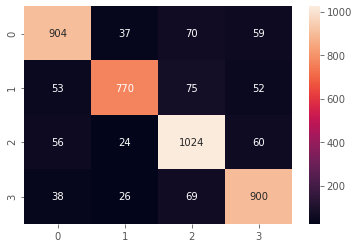

In [220]:
#performance in training set
from sklearn.metrics import confusion_matrix
import seaborn as sn

sn.heatmap(confusion_matrix(y2, gs2.predict(X2)), annot = True, fmt = '.20g')

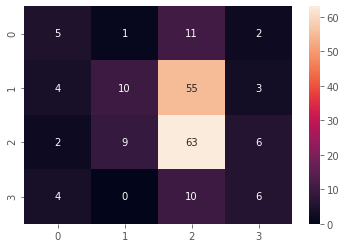

In [218]:
#performance in test set
sn.heatmap(confusion_matrix(y_test2, gs2.predict(X_test2)), annot = True, fmt = '.20g')

# LSTM for Stock Prediction  
In this section, I implement LSTM as my final model to predict classified stock returns. One of the biggest advantages of LSTM is that it incorporates time order when training time series data, compared with XGBoost and a large amount of machine learning models. Though interpretation is difficult, the learning algorithm of RNN will summarize time series patterns and get an "edge" in predicting High returns. 

In [10]:
#traing set and test set
from tensorflow.keras.utils import to_categorical

total_data = pd.concat([data, data_test]).reset_index(drop = True)
Train_Test = Transformation(total_data)

Modify Factor in [7295, 34361, 47472]


In [15]:
#data before 2017 as training set, after 2017 as test set
Train = Train_Test[Train_Test.index.year != 2017].copy()
Test = Train_Test[Train_Test.index.year == 2017].copy()

## TimeSeriesGenerator & Normalization  
Before implementing LSTM, I create windows in each time step and normalize features in each window, only using past information to avoid looking into the future.

In [109]:
from sklearn.preprocessing import StandardScaler
from pickle import dump, load

#save standard scaler of training set for further usage in test set in the form of pickle
scaler_training = StandardScaler()
scaler_training.fit(Train.iloc[:,:-1])
dump(scaler_training, open('scaler.pkl', 'wb'))

In [110]:
#create 3-dimension data:(examples, time_length, num_features)
def create_trainingset(dataset,time_step=1):
    dataX = []
    scaler = StandardScaler()
    for i in range(len(dataset)-time_step+1):
        normal = scaler.fit_transform(dataset[:(i+time_step),:-1].copy())   #normalize each window step 
        a= normal[-1*time_step:,:]
        dataX.append(a)
    dataY = dataset[9:,-1]
    return np.array(dataX),dataY

def create_testset(dataset,time_step,scaler):
    dataX = []
    for i in range(len(dataset)-time_step+1):
        normal = scaler.transform(dataset[:(i+time_step),:-1].copy())   #normalize test set using scaler with parameters from training set
        a= normal[-1*time_step:,:]
        dataX.append(a)
    dataY = dataset[9:,-1]
    return np.array(dataX),dataY

In [111]:
#get training and test X, y
length = 10   #10 window length
scaler_training = load(open('scaler.pkl', 'rb'))  #load scaler in training set

X, y = create_trainingset(Train.values, length)
X_test, y_test = create_testset(Test.values, length, scaler_training)
y = to_categorical(y, num_classes = 4)
y_test = to_categorical(y_test, num_classes = 4)

print('training data:{}, {}'.format(X.shape, y.shape))
print('test data:{}, {}'.format(X_test.shape, y_test.shape))

training data:(4208, 10, 76), (4208, 4)
test data:(242, 10, 76), (242, 4)


## First LSTM & Error Analysis

In [212]:
#Implement a simple LSTM
from tensorflow.keras.layers import Dense , LSTM , Dropout
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(LSTM(100, activation='tanh', return_sequences = False, input_shape=(length, 76)))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               70800     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 404       
Total params: 71,204
Trainable params: 71,204
Non-trainable params: 0
_________________________________________________________________


In [213]:
history = model.fit(X, y, epochs=20, verbose=1, validation_data=(X_test, y_test)) 

Epoch 1/20
132/132 [==============================] - 2s 8ms/step - loss: 1.3756 - accuracy: 0.3001 - val_loss: 1.2119 - val_accuracy: 0.4504
Epoch 2/20
132/132 [==============================] - 1s 6ms/step - loss: 1.3140 - accuracy: 0.3712 - val_loss: 1.1634 - val_accuracy: 0.4587
Epoch 3/20
132/132 [==============================] - 1s 6ms/step - loss: 1.2883 - accuracy: 0.3902 - val_loss: 1.1863 - val_accuracy: 0.4421
Epoch 4/20
132/132 [==============================] - 1s 5ms/step - loss: 1.2480 - accuracy: 0.4361 - val_loss: 1.1635 - val_accuracy: 0.4793
Epoch 5/20
132/132 [==============================] - 1s 6ms/step - loss: 1.2176 - accuracy: 0.4463 - val_loss: 1.1679 - val_accuracy: 0.4380
Epoch 6/20
132/132 [==============================] - 1s 5ms/step - loss: 1.1806 - accuracy: 0.4715 - val_loss: 1.1586 - val_accuracy: 0.4215
Epoch 7/20
132/132 [==============================] - 1s 5ms/step - loss: 1.1399 - accuracy: 0.4950 - val_loss: 1.1582 - val_accuracy: 0.4298
Epoch 

In [125]:
def plot_train(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize = (12,6))
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'hotpink')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.figure(figsize = (12,6))
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'hotpink')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

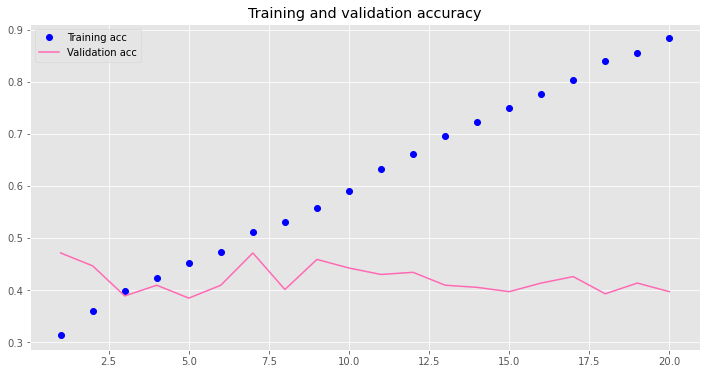

<Figure size 432x288 with 0 Axes>

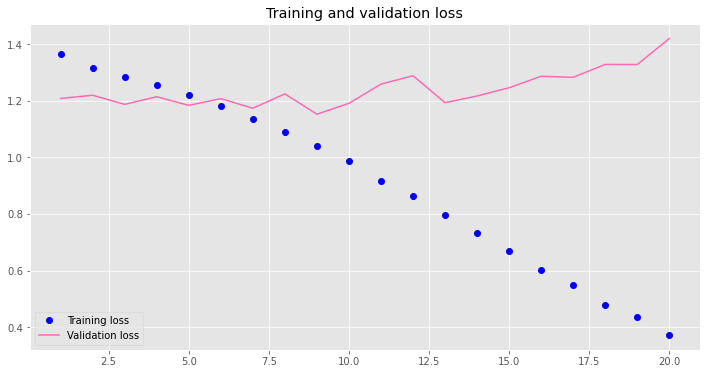

In [126]:
#plot training and validation accuracy and loss
plot_train(history)

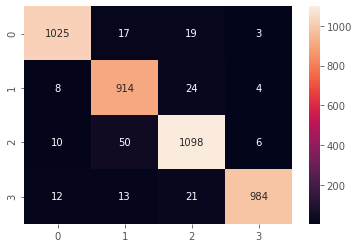

In [127]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

#draw confusion matrix
sn.heatmap(confusion_matrix(np.argmax(y, axis = 1), np.argmax(model.predict(X), axis = 1)), annot = True, fmt = '.20g')

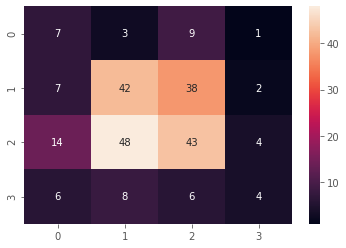

In [128]:
sn.heatmap(confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(model.predict(X_test), axis = 1)), annot = True, fmt = '.20g')

## Modified LSTM  
Based on the above error analysis, I further modify the hyperparameters of LSTM to make it more aggresive in predictions as well as avoid overfitting.

In [181]:
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow import keras

#Notice I will run hyperparameter tunning process three times with different optimizer SGD, adam, adagrad in order not to make each tunning process take a really long time.
def build_model_Adam(hp):
    model = Sequential()

    model.add(LSTM(units = hp.Int('units', min_value = 60, max_value = 120, step = 10), 
                   activation = hp.Choice('activation', values = ['tanh','relu','sigmoid']), 
                   return_sequences = False, kernel_regularizer = L2(0.01), name = 'LSTM', input_shape=(length, 76)))
    
    model.add(Dropout(0.2))
    model.add(Dense(units = hp.Int('units', min_value = 20, max_value = 50, step = 10) ,
                           activation = 'relu', name = 'dense_1', kernel_initializer='random_normal'))
    
    model.add(Dense(4 ,activation = "softmax" , name = "dense_head"))
    
    model.compile(
            optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values = [0.005, 0.01, 0.001])),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy']
    )
    
    return model

def build_model_SGD(hp):
    model = Sequential()

    model.add(LSTM(units = hp.Int('units', min_value = 60, max_value = 120, step = 10), 
                   activation = hp.Choice('activation', values = ['tanh','relu','sigmoid']), 
                   return_sequences = False, kernel_regularizer = L2(0.01), name = 'LSTM', input_shape=(length, 76)))
    
    model.add(Dropout(0.2))
    model.add(Dense(units = hp.Int('units', min_value = 20, max_value = 50, step = 10) ,
                           activation = 'relu', name = 'dense_1', kernel_initializer='random_normal'))
    
    model.add(Dense(4 ,activation = "softmax" , name = "dense_head"))
    
    model.compile(
            optimizer = keras.optimizers.SGD(hp.Choice('learning_rate', values = [0.005, 0.01, 0.001])),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy']
    )
    
    return model

def build_model_Adagrad(hp):
    model = Sequential()

    model.add(LSTM(units = hp.Int('units', min_value = 60, max_value = 120, step = 10), 
                   activation = hp.Choice('activation', values = ['tanh','relu','sigmoid']), 
                   return_sequences = False, kernel_regularizer = L2(0.01), name = 'LSTM', input_shape=(length, 76)))
    
    model.add(Dropout(0.2))
    model.add(Dense(units = hp.Int('units', min_value = 20, max_value = 50, step = 10) ,
                           activation = 'relu', name = 'dense_1', kernel_initializer='random_normal'))
    
    model.add(Dense(4 ,activation = "softmax" , name = "dense_head"))
    
    model.compile(
            optimizer = keras.optimizers.Adagrad(hp.Choice('learning_rate', values = [0.005, 0.01, 0.001])),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy']
    )
    
    return model

In [178]:
#Hyperparameter Tunning
import keras_tuner as kt
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

tuner = kt.RandomSearch(
    build_model_Adam,
    objective='val_accuracy',
    executions_per_trial = 2, 
    directory ='Adam',
    overwrite=True,
    max_trials=20) 

tuner.search(X, y, epochs=20, validation_data=(X_test, y_test), callbacks = [early_stopping])

Trial 20 Complete [00h 00m 26s]
val_accuracy: 0.5123967081308365

Best val_accuracy So Far: 0.6012396514415741
Total elapsed time: 00h 07m 23s
INFO:tensorflow:Oracle triggered exit


In [179]:
tuner.results_summary()
#tanh is much better 

Results summary
Results in Adam\untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 110
activation: tanh
learning_rate: 0.001
Score: 0.6012396514415741
Trial summary
Hyperparameters:
units: 100
activation: tanh
learning_rate: 0.001
Score: 0.5640495717525482
Trial summary
Hyperparameters:
units: 110
activation: tanh
learning_rate: 0.005
Score: 0.5578512251377106
Trial summary
Hyperparameters:
units: 80
activation: tanh
learning_rate: 0.005
Score: 0.5454545617103577
Trial summary
Hyperparameters:
units: 70
activation: tanh
learning_rate: 0.005
Score: 0.5123967081308365
Trial summary
Hyperparameters:
units: 90
activation: tanh
learning_rate: 0.01
Score: 0.4669421464204788
Trial summary
Hyperparameters:
units: 60
activation: tanh
learning_rate: 0.01
Score: 0.4669421464204788
Trial summary
Hyperparameters:
units: 110
activation: sigmoid
learning_rate: 0.001
Score: 0.4607437998056412
Trial summary
Hyperparameters:
unit

In [182]:
tuner1 = kt.RandomSearch(
    build_model_SGD,
    objective='val_accuracy',
    executions_per_trial = 2, 
    directory ='SGD',
    overwrite=True,
    max_trials=20) 

tuner1.search(X, y, epochs=20, validation_data=(X_test, y_test), callbacks = [early_stopping])

Trial 20 Complete [00h 00m 38s]
val_accuracy: 0.4566115736961365

Best val_accuracy So Far: 0.4669421464204788
Total elapsed time: 00h 10m 59s
INFO:tensorflow:Oracle triggered exit


In [184]:
tuner1.results_summary()
#SGD much worse than Adam

Results summary
Results in SGD\untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 60
activation: tanh
learning_rate: 0.01
Score: 0.4669421464204788
Trial summary
Hyperparameters:
units: 70
activation: relu
learning_rate: 0.005
Score: 0.4607437998056412
Trial summary
Hyperparameters:
units: 90
activation: relu
learning_rate: 0.001
Score: 0.4607437998056412
Trial summary
Hyperparameters:
units: 90
activation: tanh
learning_rate: 0.001
Score: 0.4607437998056412
Trial summary
Hyperparameters:
units: 100
activation: relu
learning_rate: 0.01
Score: 0.4586776942014694
Trial summary
Hyperparameters:
units: 120
activation: relu
learning_rate: 0.001
Score: 0.4586776942014694
Trial summary
Hyperparameters:
units: 100
activation: relu
learning_rate: 0.001
Score: 0.4566115736961365
Trial summary
Hyperparameters:
units: 120
activation: tanh
learning_rate: 0.001
Score: 0.4566115736961365
Trial summary
Hyperparameters:
units: 1

In [183]:
tuner2 = kt.RandomSearch(
    build_model_Adagrad,
    objective='val_accuracy',
    executions_per_trial = 2, 
    directory ='Adagrad',
    overwrite=True,
    max_trials=20) 

tuner2.search(X, y, epochs=20, validation_data=(X_test, y_test), callbacks = [early_stopping])

Trial 20 Complete [00h 00m 31s]
val_accuracy: 0.45041322708129883

Best val_accuracy So Far: 0.4793388396501541
Total elapsed time: 00h 11m 24s
INFO:tensorflow:Oracle triggered exit


In [185]:
tuner2.results_summary()
#Adagrad much worse than Adam

Results summary
Results in Adagrad\untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 120
activation: relu
learning_rate: 0.01
Score: 0.4793388396501541
Trial summary
Hyperparameters:
units: 110
activation: relu
learning_rate: 0.01
Score: 0.47314049303531647
Trial summary
Hyperparameters:
units: 80
activation: relu
learning_rate: 0.01
Score: 0.46900826692581177
Trial summary
Hyperparameters:
units: 120
activation: tanh
learning_rate: 0.005
Score: 0.46694216132164
Trial summary
Hyperparameters:
units: 120
activation: relu
learning_rate: 0.005
Score: 0.46694216132164
Trial summary
Hyperparameters:
units: 100
activation: relu
learning_rate: 0.005
Score: 0.46487604081630707
Trial summary
Hyperparameters:
units: 80
activation: tanh
learning_rate: 0.001
Score: 0.4607437998056412
Trial summary
Hyperparameters:
units: 60
activation: sigmoid
learning_rate: 0.001
Score: 0.4586776942014694
Trial summary
Hyperparameters:
un

In [196]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True) #more tolerance to stop model

final_model = Sequential()
final_model.add(LSTM(units = 110, activation = 'tanh', return_sequences = False, 
                     kernel_regularizer = L2(0.01), name = 'LSTM', input_shape=(length, 76)))
final_model.add(Dropout(0.2))
final_model.add(Dense(units = 40, activation = 'relu', name = 'dense_1', kernel_initializer='random_normal'))
final_model.add(Dense(4 ,activation = "softmax" , name = "dense_head"))

final_model.compile(optimizer = keras.optimizers.Adam(0.001),
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

final_history = final_model.fit(X, y, epochs=300, verbose=1, validation_data=(X_test, y_test), callbacks = [early_stopping])

Epoch 1/300
132/132 [==============================] - 3s 8ms/step - loss: 1.7382 - accuracy: 0.3256 - val_loss: 1.2559 - val_accuracy: 0.4504
Epoch 2/300
132/132 [==============================] - 1s 7ms/step - loss: 1.3723 - accuracy: 0.3372 - val_loss: 1.2412 - val_accuracy: 0.4504
Epoch 3/300
132/132 [==============================] - 1s 6ms/step - loss: 1.3539 - accuracy: 0.3401 - val_loss: 1.1964 - val_accuracy: 0.4339
Epoch 4/300
132/132 [==============================] - 1s 6ms/step - loss: 1.3470 - accuracy: 0.3439 - val_loss: 1.2472 - val_accuracy: 0.4504
Epoch 5/300
132/132 [==============================] - 1s 6ms/step - loss: 1.3465 - accuracy: 0.3477 - val_loss: 1.1900 - val_accuracy: 0.4504
Epoch 6/300
132/132 [==============================] - 1s 6ms/step - loss: 1.3413 - accuracy: 0.3448 - val_loss: 1.2518 - val_accuracy: 0.4421
Epoch 7/300
132/132 [==============================] - 1s 6ms/step - loss: 1.3373 - accuracy: 0.3612 - val_loss: 1.1787 - val_accuracy: 0.4463

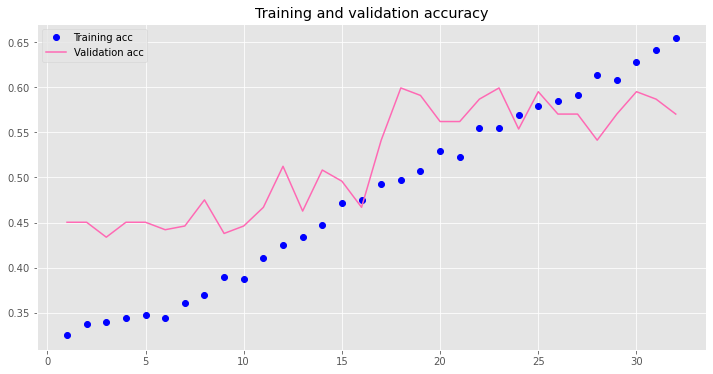

<Figure size 432x288 with 0 Axes>

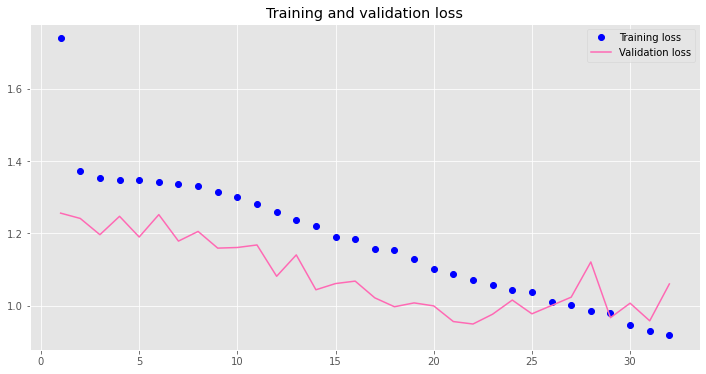

In [200]:
plot_train(final_history)

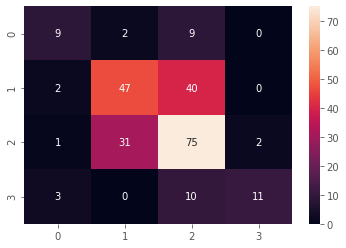

In [201]:
#confusion matrix in validation set
sn.heatmap(confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(final_model.predict(X_test), axis = 1)), annot = True, fmt = '.20g')

In [210]:
#define a function to evaluate performance
def performance(yr, yp):
    
    precision_0 = 0
    win_ratio_0 = 0
    precision_3 = 0
    win_ratio_3 = 0
    
    df = {}
    df['yr'] = yr
    df['yp'] = yp
    df = pd.DataFrame(df, index = range(len(yr)))
    
    #label 0
    tmp0 = df[df['yp'] == 0].copy()
    if len(tmp0) == 0:
        print('No label is predicted as 0!')
    else:
        precision_0 = len(tmp0[tmp0['yr'] == 0])/len(tmp0)
        win_ratio_0 = len(tmp0[tmp0['yr'].isin([0,1])])/len(tmp0)
    
    #label 3
    tmp3 = df[df['yp'] == 3].copy()
    if len(tmp3) == 0:
        print('No label is predicted as 3!')
    else:
        precision_3 = len(tmp3[tmp3['yr'] == 3])/len(tmp3)
        win_ratio_3 = len(tmp3[tmp3['yr'].isin([2,3])])/len(tmp3)
        
    return [precision_0, win_ratio_0, precision_3, win_ratio_3]

In [217]:
final_performance = performance(np.argmax(y_test, axis = 1), np.argmax(final_model.predict(X_test), axis = 1))
first_performance = performance(np.argmax(y_test, axis = 1), np.argmax(model.predict(X_test), axis = 1))

print('Final Model Performance: {}'.format(final_performance))

Final Model Performance: [0.6, 0.7333333333333333, 0.8461538461538461, 1.0]


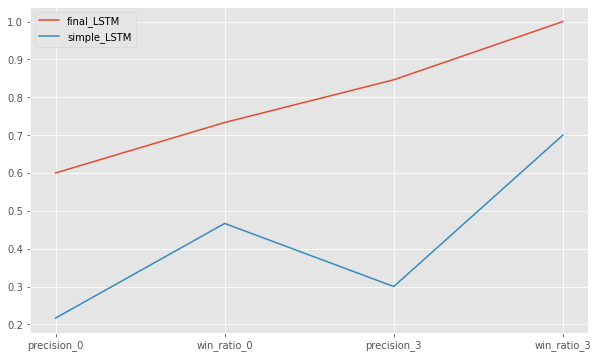

In [216]:
#Comparsion of final model and first simple LSTM
plt.figure(figsize = (10,6))
plt.plot(np.arange(4), final_performance, label = 'final_LSTM')
plt.plot(np.arange(4), first_performance, label = 'simple_LSTM')
plt.xticks(range(4), ['precision_0', 'win_ratio_0', 'precision_3', 'win_ratio_3'])
plt.legend()

In [6]:
print("Done!")

Done!
